# Predicting Demographic Attributes Using Machine Learning

This project focuses on predicting demographic attributes such as age, gender, and geographic ancestry based on facial image embeddings. The dataset contains structured feature representations extracted from images, allowing the models to classify individuals into predefined demographic categories.

Dataset: https://github.com/joojs/fairface


## 1.  Import all libraries

In [45]:
import os
import pandas as pd
import numpy as np
import shutil
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from scipy.stats import zscore

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, SeparableConv2D, BatchNormalization, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Dropout, Add, Activation, Flatten, 
    RandomFlip, RandomRotation, RandomZoom
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision

from collections import defaultdict
from PIL import Image
import imagehash

import joblib
import ast
import cv2
from sklearn.decomposition import PCA


tf.get_logger().setLevel('ERROR')
tf.config.optimizer.set_experimental_options({"disable_meta_optimizer": True})

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_METAL_LOG_LEVEL"] = "0"

from sklearn.metrics import precision_recall_curve, roc_curve, auc


## 2.  Load and Inspect the CSV Data

In [24]:
import pandas as pd
import os

# Define paths
train_csv_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/fairface_label_train.csv"
val_csv_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/fairface_label_val.csv"
train_image_dir = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/"
val_image_dir = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/val/"

# Load data
df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)

total_rows = df_train.shape[0] + df_val.shape[0]
total_columns = df_train.shape[1]

print(f"Total Rows: {total_rows}")
print(f"Total Columns: {total_columns}")

print(f"Training Data: {df_train.shape[0]} rows, {df_train.shape[1]} columns")
print(f"Validation Data: {df_val.shape[0]} rows, {df_val.shape[1]} columns")

print("\nTraining Data Sample:")
print(df_train.head())

print("\nValidation Data Sample:")
print(df_val.head())

print("\nColumn Names:")
print(df_train.columns.tolist())

print("\nMissing Values in Training Data:")
print(df_train.isnull().sum())

print("\nMissing Values in Validation Data:")
print(df_val.isnull().sum())

print("\nData Types in Training Set:")
print(df_train.dtypes)

print("\nData Types in Validation Set:")
print(df_val.dtypes)

train_images = len(os.listdir(train_image_dir))
val_images = len(os.listdir(val_image_dir))

print(f"\nNumber of images in Training Folder: {train_images}")
print(f"Number of images in Validation Folder: {val_images}")


Total Rows: 97698
Total Columns: 5
Training Data: 86744 rows, 5 columns
Validation Data: 10954 rows, 5 columns

Training Data Sample:
          file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True

Validation Data Sample:
        file    age  gender             race  service_test
0  val/1.jpg    3-9    Male       East Asian         False
1  val/2.jpg  50-59  Female       East Asian          True
2  val/3.jpg  30-39    Male            White          True
3  val/4.jpg  20-29  Female  Latino_Hispanic          True
4  val/5.jpg  20-29    Male  Southeast Asian         False

Column Names:
['file', 'age', 'gender', 'race', 'service_test']

Missing Values in Training Data:
file            0
age             0
gender          

## 3. Data Cleaning & Preprocessing

### 3.1 Dropping Unwanted Rows and Columns 

In [26]:
missing_values_train = df_train.isnull().sum()
missing_values_val = df_val.isnull().sum()

# Drop the "service_test" column 
if "service_test" in df_train.columns:
    df_train = df_train.drop(columns=["service_test"])
if "service_test" in df_val.columns:
    df_val = df_val.drop(columns=["service_test"])


missing_values_train, missing_values_val

(file            0
 age             0
 gender          0
 race            0
 service_test    0
 dtype: int64,
 file            0
 age             0
 gender          0
 race            0
 service_test    0
 dtype: int64)

### 3.2 Ensuring Label Consistency

In [29]:
def check_label_consistency(df, column_name):
    """
    Checks unique values in a given column to detect inconsistencies.

    Parameters:
    df (DataFrame): The dataset containing categorical labels.
    column_name (str): The name of the column to check.

    Returns:
    set: A set of unique values found in the column.
    """
    unique_values = set(df[column_name].dropna().unique())  # Remove NaN values before checking
    return unique_values

def standardize_labels(df, column_name, corrections):
    """
    Standardizes label values in a dataset column by:
    - Converting all text to lowercase
    - Removing extra spaces
    - Applying predefined corrections
    - Capitalizing the first letter of each word

    Parameters:
    df (DataFrame): The dataset containing categorical labels.
    column_name (str): The name of the column to standardize.
    corrections (dict): A dictionary mapping incorrect values to corrected values.

    Returns:
    DataFrame: Updated DataFrame with standardized labels.
    """
    # Convert to lowercase and remove extra spaces
    df[column_name] = df[column_name].astype(str).str.strip().str.lower()

    # Apply corrections
    df[column_name] = df[column_name].replace(corrections)

    # Capitalize first letter of each word
    df[column_name] = df[column_name].apply(lambda x: x.title())

    return df


print("\nChecking unique values before fixing inconsistencies:")
print("Unique values in 'gender':", check_label_consistency(df_train, "gender"))
print("Unique values in 'race':", check_label_consistency(df_train, "race"))



# Define corrections for inconsistencies
corrections_gender = {
    "male": "Male",
    "female": "Female"
}

corrections_race = {
    "east_asian": "East Asian",
    "south asian": "Indian",  # Ensure correctness based on dataset
    "black_african": "Black",
    "white european": "White"
}

#  Apply standardization to both training and validation sets
df_train = standardize_labels(df_train, "gender", corrections_gender)
df_train = standardize_labels(df_train, "race", corrections_race)
df_val = standardize_labels(df_val, "gender", corrections_gender)
df_val = standardize_labels(df_val, "race", corrections_race)


print("\nChecking unique values after fixing inconsistencies:")
print("Unique values in 'gender':", check_label_consistency(df_train, "gender"))
print("Unique values in 'race':", check_label_consistency(df_train, "race"))





Checking unique values before fixing inconsistencies:
Unique values in 'gender': {'Female', 'Male'}
Unique values in 'race': {'Black', 'Indian', 'East Asian', 'Latino_Hispanic', 'White', 'Southeast Asian', 'Middle Eastern'}

Checking unique values after fixing inconsistencies:
Unique values in 'gender': {'Female', 'Male'}
Unique values in 'race': {'Black', 'Indian', 'East Asian', 'Latino_Hispanic', 'White', 'Southeast Asian', 'Middle Eastern'}


### 3.3 Fixing File Paths

The file column in the CSV originally contained folder paths (e.g., train/faces/1.jpg), but we need only the image filenames (1.jpg). Removing folder paths ensures flexibility when accessing images, allowing us to dynamically specify directories during data loading, making the dataset structure cleaner and more adaptable.

In [13]:
def clean_filenames(df):
    """
    Standardizes filenames by:
    - Keeping only the image filename (removing full directory paths)
    - Converting filenames to lowercase for consistency
    - Stripping any unnecessary spaces

    Parameters:
    df (DataFrame): The dataset containing image file names.

    Returns:
    DataFrame: Updated DataFrame with clean filenames.
    """
    df["file"] = df["file"].astype(str).apply(lambda x: os.path.basename(x.strip().lower()))
    return df


print("\nFile Paths in Train CSV (Before Fix):")
print(df_train["file"].head())

print("\nFile Paths in Validation CSV (Before Fix):")
print(df_val["file"].head())

df_train = clean_filenames(df_train)
df_val = clean_filenames(df_val)

# Display file paths after cleaning
print("\nFile Paths in Train CSV (After Fix):")
print(df_train["file"].head())

print("\nFile Paths in Validation CSV (After Fix):")
print(df_val["file"].head())


print("\nFile paths have been standardized and updated in the dataset.")





File Paths in Train CSV (Before Fix):
0    train/1.jpg
1    train/2.jpg
2    train/3.jpg
3    train/4.jpg
4    train/5.jpg
Name: file, dtype: object

File Paths in Validation CSV (Before Fix):
0    val/1.jpg
1    val/2.jpg
2    val/3.jpg
3    val/4.jpg
4    val/5.jpg
Name: file, dtype: object

File Paths in Train CSV (After Fix):
0    1.jpg
1    2.jpg
2    3.jpg
3    4.jpg
4    5.jpg
Name: file, dtype: object

File Paths in Validation CSV (After Fix):
0    1.jpg
1    2.jpg
2    3.jpg
3    4.jpg
4    5.jpg
Name: file, dtype: object

File paths have been standardized and updated in the dataset.


### 3.4 Finding Missing Images

The CSV file may reference images that do not actually exist in the dataset. Checking for missing images ensures that all images listed in the dataset are available, preventing errors during data loading and model training. If missing images are found, we can either remove those entries from the dataset or investigate why they are missing.

In [16]:
def check_missing_images(df, image_dir):
    """
    Checks whether all images listed in the dataset CSV exist in the dataset directory.

    Parameters:
    df (DataFrame): The dataset containing image file names.
    image_dir (str): Directory where images are stored.

    Returns:
    DataFrame: A subset of df containing entries with missing images.
    """

    image_files = set(f.lower() for f in os.listdir(image_dir))

    # Identify missing images by checking if filenames exist in the directory
    missing_images = df[~df["file"].str.lower().isin(image_files)]
    
    return missing_images


missing_train = check_missing_images(df_train, train_image_dir)
missing_val = check_missing_images(df_val, val_image_dir)


print(f"Total images in train folder: {len(os.listdir(train_image_dir))}")
print(f"Total images in validation folder: {len(os.listdir(val_image_dir))}")

print(f"Total train images expected by CSV: {len(df_train)}")
print(f"Total train images actually present: {len(os.listdir(train_image_dir))}")
print(f"Total missing train images: {len(missing_train)}")

print(f"Total validation images expected by CSV: {len(df_val)}")
print(f"Total validation images actually present: {len(os.listdir(val_image_dir))}")
print(f"Total missing validation images: {len(missing_val)}")



Total images in train folder: 86744
Total images in validation folder: 10954
Total train images expected by CSV: 86744
Total train images actually present: 86744
Total missing train images: 0
Total validation images expected by CSV: 10954
Total validation images actually present: 10954
Total missing validation images: 0


### 3.5  Detecting and Removing Duplicate Images

**Step 1: Print & Verify Duplicate Groups Before Deleting**


We should print a few examples of detected duplicates along with their hashes to confirm they are truly identical.

**Code to Print & Verify Duplicates**

In [19]:
def compute_image_hash(image_path):
    """
    Computes the perceptual hash (pHash) of an image to detect duplicates.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    str or None: The perceptual hash as a string, or None if an error occurs.
    """
    try:
        with Image.open(image_path) as img:
            return str(imagehash.phash(img))  # Convert hash to string for comparison
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None  # Return None if processing fails

def find_duplicates(image_dir):
    """
    Identifies duplicate images in a directory using perceptual hashing.

    Parameters:
    image_dir (str): Path to the dataset directory.

    Returns:
    dict: A dictionary mapping hash values to lists of duplicate image paths.
    """
    hashes = defaultdict(list)
    
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        
        # Ensure file is an image before processing
        if os.path.isfile(img_path) and img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_hash = compute_image_hash(img_path)
            if img_hash:
                hashes[img_hash].append(img_path)
    
    # Keep only hash groups with more than 1 image (duplicates)
    duplicates = {h: paths for h, paths in hashes.items() if len(paths) > 1}
    
    return duplicates


train_duplicates = find_duplicates(train_image_dir)
val_duplicates = find_duplicates(val_image_dir)


print(f"\nTotal duplicate groups in Train Set: {len(train_duplicates)}")
print(f"Total duplicate groups in Validation Set: {len(val_duplicates)}")


for hash_key, paths in list(train_duplicates.items())[:5]:
    print(f"\nDuplicate Hash: {hash_key}")
    print(f"Duplicate Images: {paths}")



Total duplicate groups in Train Set: 179
Total duplicate groups in Validation Set: 3

Duplicate Hash: a239074b21ee74b7
Duplicate Images: ['/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/38446.jpg', '/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/71389.jpg']

Duplicate Hash: 81e59bc2959b6339
Duplicate Images: ['/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/25371.jpg', '/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/15679.jpg']

Duplicate Hash: b7193000665f6fda
Duplicate Images: ['/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/16591.jpg', '/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/12322.jpg']

Duplicate Hash: 9c53a66b4eb55498
Duplicate Images: ['/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/66062.jpg', '/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/19308.jpg'

**Step 2: Manual Check a Few Duplicate Pairs**

Before removing them, checking a few duplicate image pairs to visually confirm if they are the same.


Displaying Train Set Duplicates:


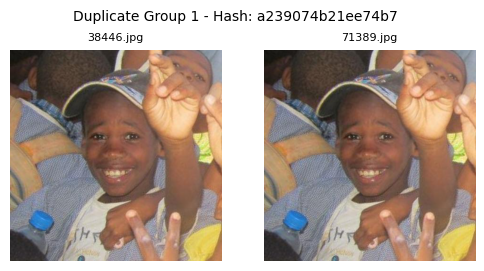

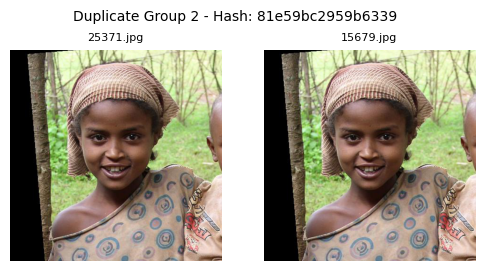

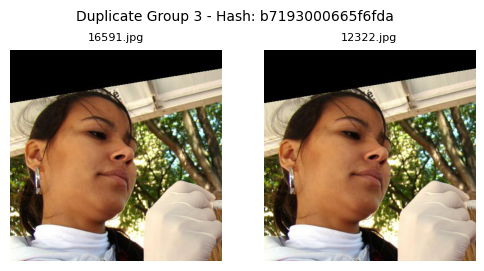


Displaying Validation Set Duplicates:


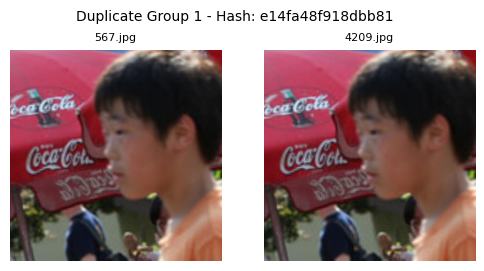

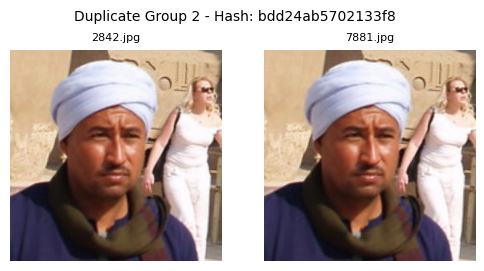

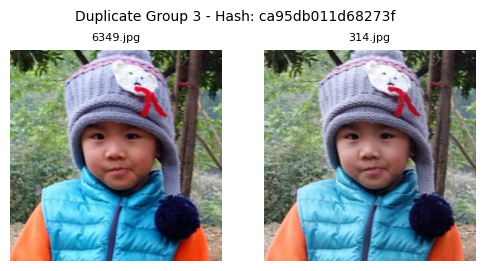

In [21]:

def display_duplicate_images(duplicates_dict, num_samples=3):
    """
    Displays duplicate image pairs in Jupyter Notebook for verification.

    Parameters:
    duplicates_dict (dict): Dictionary mapping hash values to image paths.
    num_samples (int): Number of duplicate groups to display.
    """
    # Get a sample of duplicate groups, ensuring we do not exceed available duplicates
    sample_duplicates = list(duplicates_dict.items())[:min(num_samples, len(duplicates_dict))]

    if not sample_duplicates:
        print("No duplicate images found.")
        return

    for i, (hash_key, paths) in enumerate(sample_duplicates):
        num_images = len(paths)
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

        # Handle case where there's only one duplicate (not a list of axes)
        if num_images == 1:
            axes = [axes]

        for ax, img_path in zip(axes, paths):
            try:
                with Image.open(img_path) as img:
                    ax.imshow(img)
                    ax.set_title(os.path.basename(img_path), fontsize=8)
                    ax.axis("off")
            except Exception as e:
                print(f"Error displaying {img_path}: {e}")
                ax.axis("off")

        plt.suptitle(f"Duplicate Group {i+1} - Hash: {hash_key}", fontsize=10)
        plt.show()


print("\nDisplaying Train Set Duplicates:")
display_duplicate_images(train_duplicates)

print("\nDisplaying Validation Set Duplicates:")
display_duplicate_images(val_duplicates)



**Step 3: Removing Verified Duplicates from Folder and CSV**

After detecting duplicate images, the following steps are required:

* Deleting duplicate image files from the dataset folder (keep only one copy).
* Removing duplicate file entries from the dataset CSV to maintain consistency.




In [23]:
def remove_duplicates_from_folder_and_csv(duplicates_dict, df, image_dir):
    """
    Removes duplicate images from the dataset folder and updates the dataset CSV.

    Parameters:
    duplicates_dict (dict): Dictionary mapping hash values to lists of duplicate file paths.
    df (DataFrame): The dataset CSV to update.
    image_dir (str): Directory where images are stored.

    Returns:
    DataFrame: Updated DataFrame without duplicate entries.
    """
    removed_files = []  # Store removed filenames for reference

    for paths in duplicates_dict.values():
        # Keep the first image, delete the rest
        for duplicate_img in paths[1:]:
            if os.path.exists(duplicate_img):  # Check if the file exists before deleting
                try:
                    os.remove(duplicate_img)  # Remove file from directory
                    removed_files.append(os.path.basename(duplicate_img))  # Store deleted filename
                    print("\n Deleted File",duplicate_img)
                except Exception as e:
                    print("Error deleting", duplicate_img, ":", e)
            else:
                print("Skipping deletion, file not found:", duplicate_img)

   
    df = df[~df["file"].isin(removed_files)].reset_index(drop=True)

    return df



df_train = remove_duplicates_from_folder_and_csv(train_duplicates, df_train, train_image_dir)
df_val = remove_duplicates_from_folder_and_csv(val_duplicates, df_val, val_image_dir)

print("Removed Duplicate Pictures Successfully")



 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/71389.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/15679.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/12322.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/19308.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/36324.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/23085.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/5159.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/8750.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/18139.jpg

 Deleted File /Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/33539.jpg

 

**Step 4: Save the Cleaned Dataset After Removing Duplicates**

Now that duplicate images have been removed, we must save the cleaned dataset.
This ensures that the dataset does not contain duplicate entries before proceeding with further cleaning or training.


In [25]:
def remove_missing_images_from_df(df, image_dir):
    """
    Removes entries from the CSV where the image file does not exist in the dataset folder.

    Parameters:
    csv_path (str): Path to the dataset CSV file.
    image_dir (str): Path to the dataset folder.

    Returns:
    None
    """
    
    # Clean filenames (remove paths, lowercase for consistency)
    df["file"] = df["file"].astype(str).apply(lambda x: os.path.basename(x.strip().lower()))

    # Get all filenames currently in the dataset folder
    actual_files = {file.lower() for file in os.listdir(image_dir)}

    # Keep only valid image entries
    df_cleaned = df[df["file"].isin(actual_files)].reset_index(drop=True)
    
    return df_cleaned

# Run fix for both train and validation datasets
df_train=remove_missing_images_from_df(df_train, train_image_dir)
df_val=remove_missing_images_from_df(df_val, val_image_dir)

print("Removed Duplicate Entires for those Pictures Successfully")


Removed Duplicate Entires for those Pictures Successfully


### 3.6 Check Corrupted Images

* Some image files may be corrupted or incomplete, causing errors during data processing.
* Before training, we must ensure all images can be opened without issues.
* This step will identify corrupted images and remove them to avoid failures during model training.

In [28]:
def is_corrupt(image_path):
    """
    Checks whether an image file is corrupted.

    Parameters:
    image_path (str): Path to the image file.

    Returns:
    bool: True if the image is corrupted, False otherwise.
    """
    try:
        img = Image.open(image_path)
        img.verify()  # Verify if the image can be opened
        return False  # Image is not corrupted
    except Exception:
        return True  # Image is corrupted

def find_and_remove_corrupt_images(image_dir, df):
    """
    Identifies and removes corrupted images from the dataset folder and updates the CSV.

    Parameters:
    image_dir (str): Directory where images are stored.
    df (DataFrame): The dataset CSV to update.

    Returns:
    DataFrame: Updated DataFrame with corrupted images removed.
    """
    corrupt_images = [img for img in os.listdir(image_dir) if is_corrupt(os.path.join(image_dir, img))]
    
    print("\nTotal Corrupted Images Found:", len(corrupt_images))

    # Remove corrupted images from the folder
    for img in corrupt_images:
        try:
            os.remove(os.path.join(image_dir, img))
        except Exception as e:
            print("Error deleting", img, ":", e)

    # Remove corrupted image entries from the CSV
    df = df[~df["file"].isin(corrupt_images)].reset_index(drop=True)

    return df

# Detect and remove corrupted images from train and validation datasets
df_train = find_and_remove_corrupt_images(train_image_dir, df_train)
df_val = find_and_remove_corrupt_images(val_image_dir, df_val)

print("Corrupted images removed successfully from both folder and CSV.")



Total Corrupted Images Found: 0

Total Corrupted Images Found: 0
Corrupted images removed successfully from both folder and CSV.


### 3.7 Final Dataset Validation

In [30]:
def check_final_dataset(df, image_dir, dataset_name):
    """
    Verifies that all images listed in the dataset CSV exist in the dataset folder.

    Parameters:
    csv_path (str): Path to the cleaned dataset CSV file.
    image_dir (str): Path to the dataset folder.
    dataset_name (str): Name of the dataset (Train/Validation).

    Returns:
    None
    """

   
    df["file"] = df["file"].astype(str).apply(lambda x: os.path.basename(x.strip().lower()))


    image_files = {file.lower() for file in os.listdir(image_dir)}

    missing_files = df[~df["file"].str.lower().isin(image_files)]["file"].tolist()

    print(f"\nDataset Integrity Check: {dataset_name}")
    print("-" * 40)
    print(f"Total images listed in CSV   : {len(df):,}")
    print(f"Total images present in folder: {len(image_files):,}")
    print(f"Total missing images         : {len(missing_files):,}")

    if missing_files:
        print("-" * 40)
        print("Sample missing files:")
        for file in missing_files[:10]:
            print(f"  - {file}")
    else:
        print("Dataset check complete. No missing files detected.")


check_final_dataset(df_train, train_image_dir, "Train")
check_final_dataset(df_val, val_image_dir, "Validation")


Dataset Integrity Check: Train
----------------------------------------
Total images listed in CSV   : 86,559
Total images present in folder: 86,559
Total missing images         : 0
Dataset check complete. No missing files detected.

Dataset Integrity Check: Validation
----------------------------------------
Total images listed in CSV   : 10,951
Total images present in folder: 10,951
Total missing images         : 0
Dataset check complete. No missing files detected.


## 4. Feature Engineering 

### 4.1 Converting Age Ranges to Midpoints

The age column in the dataset is stored as categorical ranges (e.g., "10-19"), which cannot be used directly for numerical analysis or model training. Converting these ranges into midpoint values (e.g., "10-19" → 14.5) allows us to treat age as a continuous numerical feature, making it suitable for statistical analysis and machine learning models.

In [34]:

def convert_age_to_midpoint(df):
    """
    Converts age ranges to numerical midpoints.
    
    Parameters:
    df (DataFrame): The dataset containing the age column.

    Returns:
    DataFrame: Updated DataFrame with one new column:
               - 'age_midpoint': Midpoint of the age range (integer, for training)
    """
    def process_age(age):
        """Helper function to extract midpoint from the age range."""
        if pd.isna(age):  
            return None  # Handle missing values
        
        age = str(age).strip()  # Remove spaces

        if "-" in age:  
            lower, upper = map(int, age.split("-"))  
            return round((lower + upper) / 2)

        elif "more than" in age.lower():  
            return 75 

        return None  
    

    df["age_midpoint"] = df["age"].apply(process_age)

    return df


df_train = convert_age_to_midpoint(df_train)
df_val = convert_age_to_midpoint(df_val)


df_train["age_midpoint"] = df_train["age_midpoint"].astype("Int64")
df_val["age_midpoint"] = df_val["age_midpoint"].astype("Int64")


print(df_train[["age", "age_midpoint"]].head())
print(df_val[["age", "age_midpoint"]].head())


     age  age_midpoint
0  50-59            54
1  30-39            34
2    3-9             6
3  20-29            24
4  20-29            24
     age  age_midpoint
0    3-9             6
1  50-59            54
2  30-39            34
3  20-29            24
4  20-29            24


### 4.2 Encoding Age Bins

In [36]:
def encode_age_labels(df_train, df_val):
    """
    Extracts unique age labels from both datasets, assigns categorical indices, 
    and creates a new column 'age_encoded' in both datasets.

    Parameters:
        df_train (pd.DataFrame): Training dataset containing 'age' column.
        df_val (pd.DataFrame): Validation dataset containing 'age' column.

    Returns:
        pd.DataFrame, pd.DataFrame: Updated training and validation datasets.
    """
    # Extract unique age labels from both datasets
    unique_age_labels = np.sort(pd.concat([df_train["age"], df_val["age"]]).dropna().unique())

    # Create a mapping of unique age labels to categorical indices
    age_mapping = {label: idx for idx, label in enumerate(unique_age_labels)}

    # Apply the mapping to create a new encoded column 'age_encoded'
    df_train["age_encoded"] = df_train["age"].map(age_mapping)
    df_val["age_encoded"] = df_val["age"].map(age_mapping)

    # Print encoding mapping
    print("\nAge Label Encoding Mapping:")
    for label, idx in age_mapping.items():
        print(f"{label} → {idx}")

    return df_train, df_val

# Call the function
df_train, df_val = encode_age_labels(df_train, df_val)

# Display unique labels and the updated dataset
print("\nUnique Age Encodings:", np.sort(df_train["age_encoded"].unique()))
print("\nSample Data from Train Set:")
print(df_train[["age", "age_encoded"]].head())

print("\nSample Data from Validation Set:")
print(df_val[["age", "age_encoded"]].head())



Age Label Encoding Mapping:
0-2 → 0
10-19 → 1
20-29 → 2
3-9 → 3
30-39 → 4
40-49 → 5
50-59 → 6
60-69 → 7
more than 70 → 8

Unique Age Encodings: [0 1 2 3 4 5 6 7 8]

Sample Data from Train Set:
     age  age_encoded
0  50-59            6
1  30-39            4
2    3-9            3
3  20-29            2
4  20-29            2

Sample Data from Validation Set:
     age  age_encoded
0    3-9            3
1  50-59            6
2  30-39            4
3  20-29            2
4  20-29            2


### 4.3 Encoding Gender

 Encodes the gender column into numerical values (Male=0, Female=1)

In [39]:
def encode_gender(df):
    """
    Encodes the gender column into numerical values (Male=0, Female=1).

    Parameters:
    df (DataFrame): The dataset containing the gender column.

    Returns:
    DataFrame: Updated DataFrame with gender encoded.
    """
    df["gender"] = df["gender"].map({"Male": 0, "Female": 1})
    return df

# Apply gender encoding
df_train = encode_gender(df_train)
df_val = encode_gender(df_val)

# Verify encoding
print("\n Gender Encoding Applied")
print("Unique values in 'gender' column (Train):", df_train["gender"].unique())
print("Unique values in 'gender' column (Validation):", df_val["gender"].unique())




 Gender Encoding Applied
Unique values in 'gender' column (Train): [0 1]
Unique values in 'gender' column (Validation): [0 1]


### 4.4 Label Encoding for  Geographical Ancestry

This converts race categories into numerical labels (for models like  Random Forest).



In [42]:
def label_encode_geographical_ancestry(df):
    if "race" not in df.columns:
        raise KeyError("Column 'race' not found in DataFrame. Check column names.")

    df["race"].fillna("Unknown", inplace=True)
    
    encoder = LabelEncoder()
    df["race_encoded"] = encoder.fit_transform(df["race"])
    
    encoding_map = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
    decoding_map = {v: k for k, v in encoding_map.items()}

    print("\nGeographical Ancestry Label Encoding Mapping:")
    for encoded, label in decoding_map.items():
        print(f"{encoded} → {label}")

    return df, encoding_map, decoding_map


df_train, encoding_map_train, decoding_map_train = label_encode_geographical_ancestry(df_train)
df_val, encoding_map_val, decoding_map_val = label_encode_geographical_ancestry(df_val)


print("\nLabel Encoding Applied for Geographical Ancestry")
print("\nUnique values in 'race_encoded' (Train):", df_train["race_encoded"].unique())
print("\nUnique values in 'race_encoded' (Validation):", df_val["race_encoded"].unique())
print("\nLabel Encoding completed and datasets saved.")




Geographical Ancestry Label Encoding Mapping:
0 → Black
1 → East Asian
2 → Indian
3 → Latino_Hispanic
4 → Middle Eastern
5 → Southeast Asian
6 → White

Geographical Ancestry Label Encoding Mapping:
0 → Black
1 → East Asian
2 → Indian
3 → Latino_Hispanic
4 → Middle Eastern
5 → Southeast Asian
6 → White

Label Encoding Applied for Geographical Ancestry

Unique values in 'race_encoded' (Train): [1 2 0 6 4 3 5]

Unique values in 'race_encoded' (Validation): [1 6 3 5 0 2 4]

Label Encoding completed and datasets saved.


### 4.5 Adding Image Encoding In Dataset

In [44]:

base_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval"
train_image_dir = os.path.join(base_path, "train")
val_image_dir = os.path.join(base_path, "val")

def extract_simple_features(img_path):
    """Extracts grayscale pixel intensity features."""
    try:
        if not os.path.exists(img_path):
            return np.zeros((32 * 32,), dtype=np.float32)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (32, 32))
        return img_resized.flatten().astype(np.float32)
    except:
        return np.zeros((32 * 32,), dtype=np.float32)

# Extract features
df_train["image_features"] = df_train["file"].apply(lambda x: extract_simple_features(os.path.join(train_image_dir, x)))
df_val["image_features"] = df_val["file"].apply(lambda x: extract_simple_features(os.path.join(val_image_dir, x)))

# Convert features to NumPy arrays
X_train = np.stack(df_train["image_features"].values)
X_val = np.stack(df_val["image_features"].values)

# Save datasets without image features in CSV
df_train.drop(columns=["image_features"]).to_csv(os.path.join(base_path, "final_fairface_label_train.csv"), index=False)
df_val.drop(columns=["image_features"]).to_csv(os.path.join(base_path, "final_fairface_label_val.csv"), index=False)

# Save image features separately as .npy
np.save(os.path.join(base_path, "train_image_features.npy"), X_train)
np.save(os.path.join(base_path, "val_image_features.npy"), X_val)

# Load datasets
df_train = pd.read_csv(os.path.join(base_path, "final_fairface_label_train.csv"))
df_val = pd.read_csv(os.path.join(base_path, "final_fairface_label_val.csv"))

# Load image features
X_train = np.load(os.path.join(base_path, "train_image_features.npy"))
X_val = np.load(os.path.join(base_path, "val_image_features.npy"))

# Reattach NumPy features
df_train["image_features"] = list(X_train)
df_val["image_features"] = list(X_val)

# Verify data types
print(type(df_train["image_features"].iloc[0]))  # Should be numpy.ndarray
print(df_train["image_features"].dtype)  # Should be object, but contain numpy arrays


<class 'numpy.ndarray'>
object


In [45]:
display(df_train.head())
display(df_val.head())

file    age  gender        race  age_midpoint  age_encoded  race_encoded  \
0  1.jpg  50-59       0  East Asian            54            6             1   
1  2.jpg  30-39       1      Indian            34            4             2   
2  3.jpg    3-9       1       Black             6            3             0   
3  4.jpg  20-29       1      Indian            24            2             2   
4  5.jpg  20-29       1      Indian            24            2             2   

                                      image_features  
0  [0.0, 42.0, 54.0, 69.0, 79.0, 81.0, 66.0, 62.0...  
1  [122.0, 112.0, 146.0, 132.0, 112.0, 112.0, 108...  
2  [97.0, 95.0, 53.0, 86.0, 141.0, 146.0, 146.0, ...  
3  [42.0, 41.0, 38.0, 51.0, 58.0, 45.0, 39.0, 54....  
4  [139.0, 219.0, 145.0, 173.0, 199.0, 101.0, 178...

file    age  gender             race  age_midpoint  age_encoded  \
0  1.jpg    3-9       0       East Asian             6            3   
1  2.jpg  50-59       1       East Asian            54            6   
2  3.jpg  30-39       0            White            34            4   
3  4.jpg  20-29       1  Latino_Hispanic            24            2   
4  5.jpg  20-29       0  Southeast Asian            24            2   

   race_encoded                                     image_features  
0             1  [48.0, 38.0, 46.0, 57.0, 49.0, 1.0, 91.0, 97.0...  
1             1  [160.0, 153.0, 141.0, 122.0, 118.0, 107.0, 122...  
2             6  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3             3  [210.0, 210.0, 210.0, 210.0, 211.0, 211.0, 210...  
4             5  [253.0, 254.0, 254.0, 254.0, 252.0, 251.0, 251...

In [46]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_train sample:", X_train[0])  # Check a sample image feature array
print("Sum of X_train:", np.sum(X_train, axis=1))  # Ensure features have variance


X_train shape: (86559, 1024)
X_val shape: (10951, 1024)
X_train sample: [ 0. 42. 54. ...  7. 14.  9.]
Sum of X_train: [ 28232. 129954. 181490. ...  84686.  76212. 193159.]


### 4.6 Principal Component Analysis for Dimensionality Reduction 

In [48]:


def apply_pca(n_components=300):
    """Loads image features, applies PCA, and saves transformed features."""

    # Load datasets
    df_train = pd.read_csv(os.path.join(base_path, "final_fairface_label_train.csv"))
    df_val = pd.read_csv(os.path.join(base_path, "final_fairface_label_val.csv"))

    # Load image features
    X_train = np.load(os.path.join(base_path, "train_image_features.npy"))
    X_val = np.load(os.path.join(base_path, "val_image_features.npy"))

    print("Before PCA - X_train shape:", X_train.shape)
    print("Before PCA - X_val shape:", X_val.shape)

    # Ensure PCA components do not exceed the feature size
    pca_components = min(X_train.shape[1], n_components)
    pca = PCA(n_components=pca_components, random_state=42)

    # Apply PCA
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    print("After PCA - X_train shape:", X_train_pca.shape)
    print("After PCA - X_val shape:", X_val_pca.shape)

    # Save PCA-transformed features separately
    np.save(os.path.join(base_path, "train_image_features_pca.npy"), X_train_pca)
    np.save(os.path.join(base_path, "val_image_features_pca.npy"), X_val_pca)

    # Attach PCA features to DataFrames
    df_train["image_features"] = list(X_train_pca)
    df_val["image_features"] = list(X_val_pca)

    # Save updated CSVs
    df_train.to_csv(os.path.join(base_path, "final_fairface_label_train_with_pca.csv"), index=False)
    df_val.to_csv(os.path.join(base_path, "final_fairface_label_val_with_pca.csv"), index=False)

    return df_train, df_val

# Apply PCA
df_train, df_val = apply_pca(n_components=300)


Before PCA - X_train shape: (86559, 1024)
Before PCA - X_val shape: (10951, 1024)
After PCA - X_train shape: (86559, 300)
After PCA - X_val shape: (10951, 300)


In [49]:
display(df_train.head())
display(df_val.head())

file    age  gender        race  age_midpoint  age_encoded  race_encoded  \
0  1.jpg  50-59       0  East Asian            54            6             1   
1  2.jpg  30-39       1      Indian            34            4             2   
2  3.jpg    3-9       1       Black             6            3             0   
3  4.jpg  20-29       1      Indian            24            2             2   
4  5.jpg  20-29       1      Indian            24            2             2   

                                      image_features  
0  [-2147.3196, -601.0824, -40.160606, -344.06506...  
1  [910.6779, 414.22308, 136.20323, 43.222324, -4...  
2  [2366.8672, 1270.8341, 491.07413, 137.55411, 1...  
3  [-263.98877, 1389.9946, -60.24708, -456.68997,...  
4  [1008.85443, 762.0253, -43.059277, -213.69066,...

file    age  gender             race  age_midpoint  age_encoded  \
0  1.jpg    3-9       0       East Asian             6            3   
1  2.jpg  50-59       1       East Asian            54            6   
2  3.jpg  30-39       0            White            34            4   
3  4.jpg  20-29       1  Latino_Hispanic            24            2   
4  5.jpg  20-29       0  Southeast Asian            24            2   

   race_encoded                                     image_features  
0             1  [297.1504, -297.3111, -1217.6101, -638.818, -1...  
1             1  [624.92163, 15.724609, -977.34155, 503.5918, 3...  
2             6  [2369.1914, 17.209106, -322.2119, -638.94495, ...  
3             3  [2007.0645, -588.24695, 158.11554, 257.27325, ...  
4             5  [2753.2363, 117.67932, 1133.7032, -132.45306, ...

### 4.7 Saving Final Dataset

In [51]:

base_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/"
df_train.to_csv(os.path.join(base_path, "final_fairface_label_train.csv"), index=False)
df_val.to_csv(os.path.join(base_path, "final_fairface_label_val.csv"), index=False)

display(df_train.head())
display(df_val.head())

train_csv_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/final_fairface_label_train.csv"
val_csv_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/final_fairface_label_val.csv"


df_train_final = pd.read_csv(train_csv_path)
df_val_final = pd.read_csv(val_csv_path)
df_val = df_val_final
df_train = df_train_final



file    age  gender        race  age_midpoint  age_encoded  race_encoded  \
0  1.jpg  50-59       0  East Asian            54            6             1   
1  2.jpg  30-39       1      Indian            34            4             2   
2  3.jpg    3-9       1       Black             6            3             0   
3  4.jpg  20-29       1      Indian            24            2             2   
4  5.jpg  20-29       1      Indian            24            2             2   

                                      image_features  
0  [-2147.3196, -601.0824, -40.160606, -344.06506...  
1  [910.6779, 414.22308, 136.20323, 43.222324, -4...  
2  [2366.8672, 1270.8341, 491.07413, 137.55411, 1...  
3  [-263.98877, 1389.9946, -60.24708, -456.68997,...  
4  [1008.85443, 762.0253, -43.059277, -213.69066,...

file    age  gender             race  age_midpoint  age_encoded  \
0  1.jpg    3-9       0       East Asian             6            3   
1  2.jpg  50-59       1       East Asian            54            6   
2  3.jpg  30-39       0            White            34            4   
3  4.jpg  20-29       1  Latino_Hispanic            24            2   
4  5.jpg  20-29       0  Southeast Asian            24            2   

   race_encoded                                     image_features  
0             1  [297.1504, -297.3111, -1217.6101, -638.818, -1...  
1             1  [624.92163, 15.724609, -977.34155, 503.5918, 3...  
2             6  [2369.1914, 17.209106, -322.2119, -638.94495, ...  
3             3  [2007.0645, -588.24695, 158.11554, 257.27325, ...  
4             5  [2753.2363, 117.67932, 1133.7032, -132.45306, ...

In [52]:
print(df_val.dtypes)


file              object
age               object
gender             int64
race              object
age_midpoint       int64
age_encoded        int64
race_encoded       int64
image_features    object
dtype: object


## 5. Exploratory Data Analysis

### 5.1 Gender Distribution in Training Data

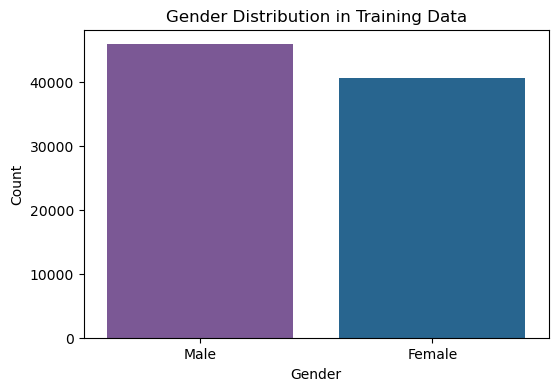

In [55]:
custom_palette = ["#7D4E9F", "#1768A0", "#41afaa"]
plt.figure(figsize=(6, 4))
sns.countplot(x="gender", data=df_train_final, palette=custom_palette[:2])  
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])
plt.title("Gender Distribution in Training Data")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()


### 5.2 Geographic Ancestryn in Training Data

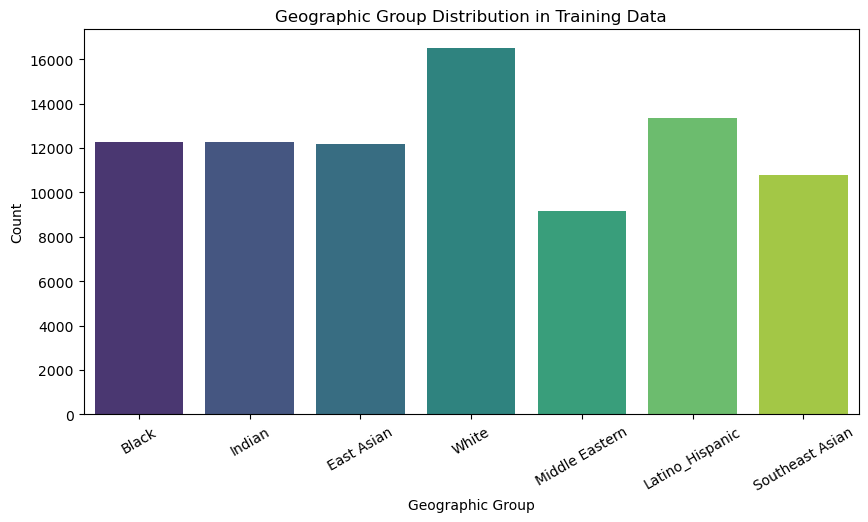

In [57]:

custom_geo_palette = sns.color_palette("viridis", n_colors=7)  # Automatically generates a gradient

geo_mapping = {
    0: "East Asian",
    1: "Black",
    2: "Indian",
    3: "Latino_Hispanic",
    4: "Middle Eastern",
    5: "Southeast Asian",
    6: "White"
}

df_train_final["geo_group"] = df_train_final["race_encoded"].map(geo_mapping)

plt.figure(figsize=(10, 5))
sns.countplot(x="geo_group", data=df_train_final, palette=custom_geo_palette)

plt.title("Geographic Group Distribution in Training Data")
plt.xlabel("Geographic Group")
plt.ylabel("Count")
plt.xticks(rotation=30)

plt.show()



### 5.3 Age Distribution in Training Data

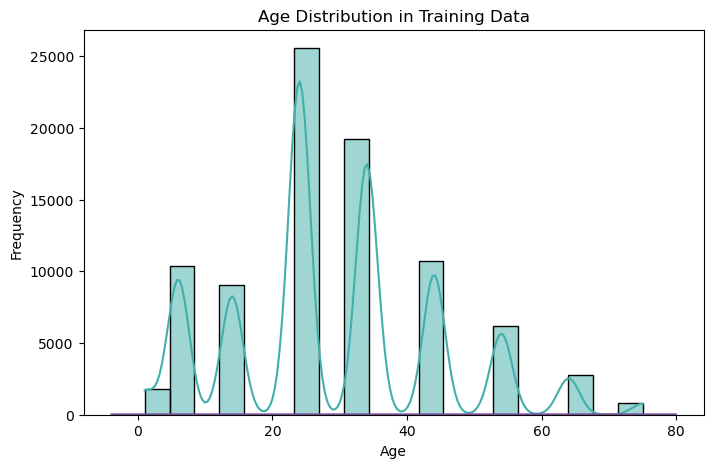

In [59]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train_final["age_midpoint"], bins=20, kde=True, color="#41AFAA", edgecolor="black")
sns.kdeplot(df_train_final["age_midpoint"], color="#7D4E9F", linewidth=2)  
plt.title("Age Distribution in Training Data")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


### 5.4 Gender vs. Age Distribution (Box Plot)

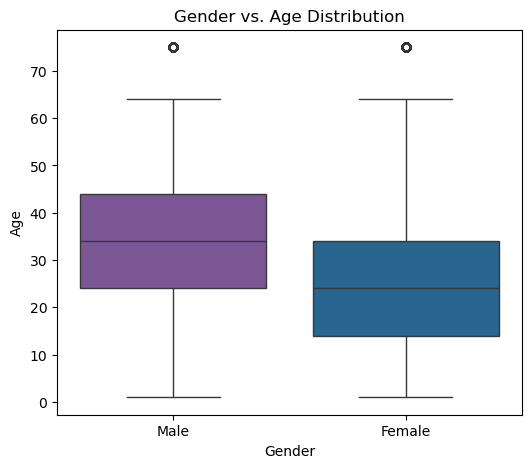

In [61]:
plt.figure(figsize=(6, 5))
sns.boxplot(x="gender", y="age_midpoint", data=df_train_final, palette=["#7D4E9F", "#1768A0"]) 
plt.xticks(ticks=[0, 1], labels=["Male", "Female"])  # Map 0 -> Male, 1 -> Female
plt.title("Gender vs. Age Distribution")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.show()


### 5.5 Geographic Ancestry vs. Age Distribution (Box Plot)

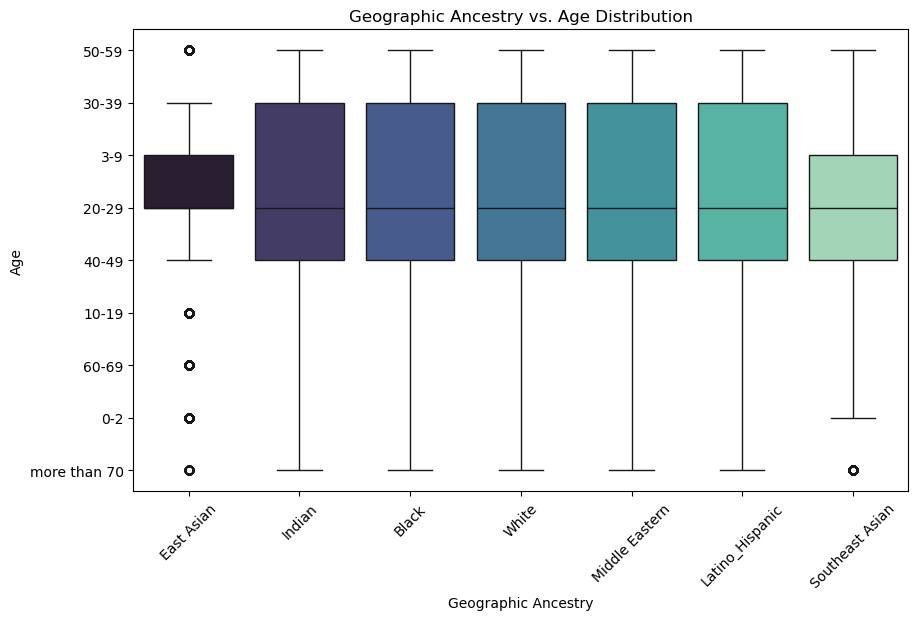

In [63]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_train,
    x="race",  
    y="age",
    palette=sns.color_palette("mako", n_colors=df_train["race"].nunique())  # Ensures proper gradient
)

plt.xlabel("Geographic Ancestry")
plt.ylabel("Age")
plt.title("Geographic Ancestry vs. Age Distribution")
plt.xticks(rotation=45)

plt.show()


### 5.6 Gender and Geographic Ances Combined (Count Plot)

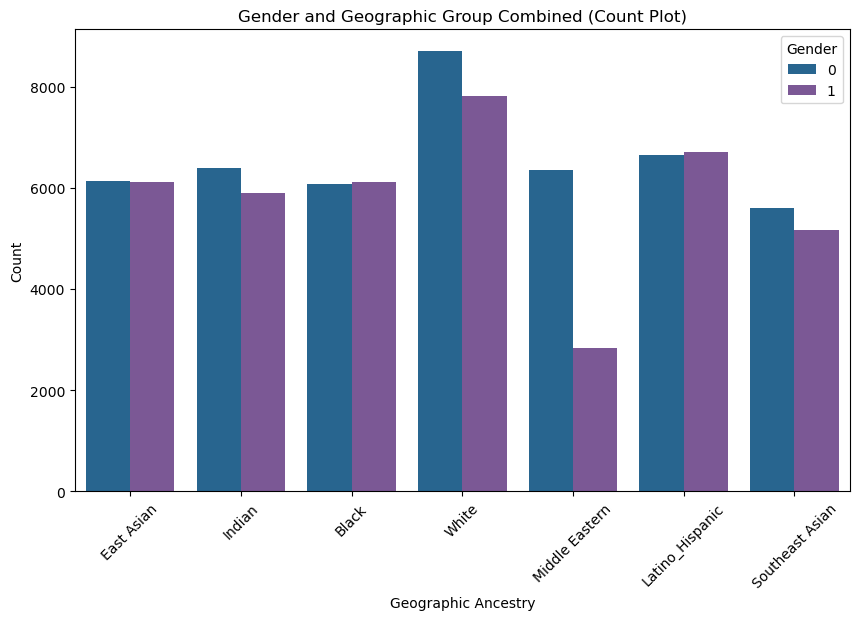

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = ["#1768A0", "#7D4E9F"]  # Colors for Male and Female

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_train, x="race", hue="gender", palette=custom_palette)

plt.xlabel("Geographic Ancestry")
plt.ylabel("Count")
plt.title("Gender and Geographic Group Combined (Count Plot)")
plt.xticks(rotation=45)

# Manually setting the legend labels
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["Male", "Female"], title="Gender")

plt.show()



### 5.7 Outlier Detection in Age

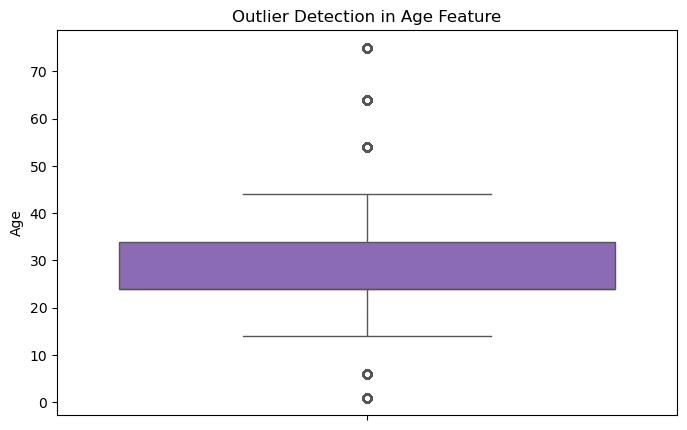

In [67]:
plt.figure(figsize=(8, 5))
sns.boxplot(y=df_train_final["age_midpoint"], palette=["#8A5FBF"])  # Red tone for highlighting outliers
plt.title("Outlier Detection in Age Feature")
plt.ylabel("Age")
plt.show()



In [68]:
# Compute Z-scores
df_train_final["age_zscore"] = zscore(df_train_final["age_midpoint"])

# Filter extreme values (Z-score > 3 or < -3)
age_outliers = df_train_final[np.abs(df_train_final["age_zscore"]) > 3]

print("Total Outliers Detected using Z-Score:", len(age_outliers))
print(age_outliers[["file", "age", "age_zscore"]].head(10))  # Display some outliers


Total Outliers Detected using Z-Score: 0
Empty DataFrame
Columns: [file, age, age_zscore]
Index: []


### 5.8 Violin Plot: Gender vs. Age Density

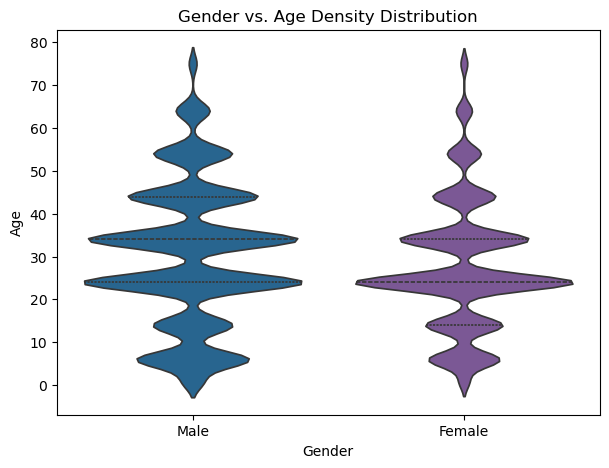

In [70]:

custom_gender_palette = ["#1768A0", "#7D4E9F"]  

plt.figure(figsize=(7, 5)) 
sns.violinplot(
    x="gender",
    y="age_midpoint",
    data=df_train_final,
    palette=custom_gender_palette,
    inner="quartile"
)

plt.xticks([0, 1], ["Male", "Female"])  
plt.title("Gender vs. Age Density Distribution")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.show()


## 6. Random Forest Model (Traditional ML)

### 6.1 Common Functions

#### 6.1.1 Utility Functions



* Checks if the predicted age falls within the given age range.

In [75]:


def safe_convert(features):
    """Fix formatting issues and convert string representation of lists to actual lists."""
    try:
        if isinstance(features, str):
            features = features.replace(" ", ",")  # Ensure commas between values
            return ast.literal_eval(features)  # Convert string to list
        return features  # If it's already a list, keep it as is
    except Exception as e:
        print(f"Conversion error: {e}")
        return [0] * 1024  # Return a placeholder if error


# Function to Check if Predicted Age Falls in the Correct Range
def is_prediction_correct(pred_age, true_age_range):
    """
    Checks if the predicted age falls within the given age range.

    Parameters:
    pred_age (float): Predicted age from the model.
    true_age_range (str): Actual age range in string format (e.g., "50-59").

    Returns:
    bool: True if the predicted age falls inside the correct bin, False otherwise.
    """
    if "-" in true_age_range:
        lower, upper = map(int, true_age_range.split("-"))
        return lower <= pred_age <= upper
    elif "more than" in true_age_range:
        return pred_age >= 70  # Handles "more than 70" case
    return False  # If the format is unexpected



#### 6.1.2 Regression: Training, Evaluation and Visualization Functions

• Converts image_features before training.

• Uses RandomForestRegressor to predict age.

• Computes standard regression evaluation metrics.

In [78]:

# Function to compute regression metrics
def compute_model_metrics(y_true, y_pred, df_val):
    """
    Computes MAE, MSE, RMSE, R² Score, and Age Bin Accuracy for the model.
    
    Parameters:
    y_true (array): True values from the validation set.
    y_pred (array): Predicted values from the model.
    df_val (DataFrame): Validation dataset containing age bins.
    
    Returns:
    pd.DataFrame: Dataframe containing the computed metrics.
    """
    

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Compute Age Bin Accuracy
    correct_predictions = [
        is_prediction_correct(pred, true_range)
        for pred, true_range in zip(y_pred, df_val["age"])
    ]
    bin_accuracy = sum(correct_predictions) / len(correct_predictions)


    results_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "R2 Score", "Age Bin Accuracy"],
        "Value": [mae, mse, rmse, r2, bin_accuracy]
    })

    return results_df


def train_random_forest_regressor(n_estimators=100, max_depth=15, min_samples_split=5):
    df_train["image_features"] = df_train["image_features"].apply(safe_convert)
    df_val["image_features"] = df_val["image_features"].apply(safe_convert)

    X_train = np.array(df_train["image_features"].tolist())
    X_val = np.array(df_val["image_features"].tolist())

    y_train_age = df_train["age_midpoint"].values
    y_val_age = df_val["age_midpoint"].values

    rf_regressor = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        n_jobs=-1,  
        random_state=42
    )
    rf_regressor.fit(X_train, y_train_age)

    # Predict age on validation set
    y_pred_age = rf_regressor.predict(X_val)

    # **Fix: Pass df_val to compute_model_metrics**
    metrics = compute_model_metrics(y_val_age, y_pred_age, df_val)

    return {"model": rf_regressor, "metrics": metrics}


In [79]:

custom_palette = ["#41afaa", "#1768A0", "#7D4E9F"]

def plot_predictions(y_true, y_pred, title):
    """
    Plots a scatter plot of actual vs predicted values.

    Parameters:
    y_true (array): True values.
    y_pred (array): Predicted values.
    title (str): Title for the graph.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.5, color=custom_palette[2], label="Predicted")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color=custom_palette[1], linestyle="--", label="Perfect Prediction")
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    """
    Plots the residual errors (True - Predicted values).

    Parameters:
    y_true (array): True values.
    y_pred (array): Predicted values.
    title (str): Title of the plot.
    """
    errors = y_true - y_pred

    plt.figure(figsize=(8, 5))
    sns.histplot(errors, bins=20, kde=True, color=custom_palette[0])
    plt.axvline(x=0, color="black", linestyle="--", label="Zero Error Line")
    plt.axvline(x=np.mean(errors), color=custom_palette[1], linestyle=":", label="Mean Error Line")  
    plt.xlabel("Prediction Error (True - Predicted)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_boxplot(y_true, y_pred, title):
    """
    Plots a boxplot comparing true and predicted values.

    Parameters:
    y_true (array): True values.
    y_pred (array): Predicted values.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=[y_true, y_pred], showfliers=True, palette=[custom_palette[0], custom_palette[2]])  
    plt.xticks([0, 1], ["True", "Predicted"])
    plt.ylabel("Value")
    plt.title(title)
    plt.show()

def plot_distribution(y_true, y_pred, title):
    """
    Plots the distribution of true vs. predicted values.

    Parameters:
    y_true (array): True values
    y_pred (array): Predicted values
    title (str): Title for the plot
    """
    plt.figure(figsize=(8, 5))
    
    sns.histplot(y_true, color="skyblue", label="True", kde=True, bins=20, stat="density", linewidth=2)
    sns.histplot(y_pred, color="purple", label="Predicted", kde=True, bins=20, alpha=0.6, stat="density", linewidth=2)
    
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.show()

def compare_models(baseline, fine_tuned):
    """
    Compares baseline and fine-tuned model performance with better R² Score visibility.

    Parameters:
    baseline (dict): Metrics from the baseline model.
    fine_tuned (dict): Metrics from the fine-tuned model.
    """
    metrics = list(baseline.keys())
    baseline_values = list(baseline.values())
    fine_tuned_values = list(fine_tuned.values())

    x = np.arange(len(metrics))

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(x[:-1] - 0.2, baseline_values[:-1], width=0.4, label="Baseline", color=custom_palette[0])
    ax1.bar(x[:-1] + 0.2, fine_tuned_values[:-1], width=0.4, label="Fine-Tuned", color=custom_palette[2])

    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.set_xlabel("Metrics")
    ax1.set_ylabel("Values (Log Scale for MSE & RMSE)")
    ax1.set_yscale("log")
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()

    # Fix: Use "R2 Score" instead of "R2_Score"
    r2_baseline = baseline.get("R2 Score", 0)
    r2_fine_tuned = fine_tuned.get("R2 Score", 0)

    r2_baseline_scaled = r2_baseline * 10  
    r2_fine_tuned_scaled = r2_fine_tuned * 10

    ax2.bar(x[-1] - 0.1, r2_baseline_scaled, width=0.2, label="Baseline R²", color=custom_palette[0])
    ax2.bar(x[-1] + 0.1, r2_fine_tuned_scaled, width=0.2, label="Fine-Tuned R²", color=custom_palette[2])

    ax2.set_ylabel("R² Score (Scaled x10 for Visibility)")
    ax2.set_ylim(0, 10)
    ax2.legend(loc="upper left")

    plt.title("Comparison of Baseline vs Fine-Tuned Model")
    plt.show()






#### 6.1.3 Classification: Training, Evaluation and Visualization Functions

• Works for both gender and race classification.
    
• Returns trained model for future predictions.
    
• Computes accuracy and classification report.

In [82]:
def train_random_forest_classifier(target_column, n_estimators=100, max_depth=15, min_samples_split=5):
    """
    Trains a Random Forest Classifier for categorical prediction.

    Parameters:
    target_column (str): The target variable (e.g., "gender" or "race").
    n_estimators (int): Number of trees in the forest.
    max_depth (int): Maximum depth of the tree.
    min_samples_split (int): Minimum samples required to split an internal node.

    Returns:
    dict: Contains accuracy, classification report, and the trained model.
    """
    # Convert image features
    df_train["image_features"] = df_train["image_features"].apply(safe_convert)
    df_val["image_features"] = df_val["image_features"].apply(safe_convert)

    # Convert features to NumPy arrays
    X_train = np.array(df_train["image_features"].tolist())
    y_train = df_train[target_column].values

    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )


    # Train the model
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
        random_state=42, n_jobs=1
    )
    rf_classifier.fit(X_train, y_train)

    # Predict on validation set
    X_val = np.array(df_val["image_features"].tolist())
    y_pred = rf_classifier.predict(X_val)

    # Compute metrics
    accuracy = accuracy_score(df_val[target_column].values, y_pred)
    class_report = classification_report(df_val[target_column].values, y_pred)

    return {
        "Target": target_column,
        "Accuracy": accuracy,
        "Classification Report": class_report,
        "Model": rf_classifier
    }



In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix


custom_palette = ["#41afaa", "#1768A0", "#7D4E9F"]


def plot_confusion_matrix(y_true, y_pred, labels, title):
    """
    Plots a confusion matrix with enhanced readability and no black grid lines.

    Parameters:
    y_true (array): True labels.
    y_pred (array): Predicted labels.
    labels (list): List of class labels.
    title (str): Title for the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, 
                linewidths=0, annot_kws={"size": 12})  # Removed black grid lines

    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=30, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()


def print_classification_report(y_true, y_pred, target_name, class_labels):
    """
    Prints a formatted classification report.

    Parameters:
    y_true (array): True labels.
    y_pred (array): Predicted labels.
    target_name (str): Name of the target variable.
    class_labels (dict): Mapping numerical labels to categorical labels.
    """
    y_true_labels = [class_labels[val] for val in y_true]
    y_pred_labels = [class_labels[val] for val in y_pred]

    report_dict = classification_report(y_true_labels, y_pred_labels, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T.iloc[:-3].round(3)

    print(f"\nClassification Report for {target_name} Model:\n")
    display(report_df)  # Jupyter-friendly display


def plot_classification_metrics(y_true, y_pred, title):
    """
    Plots Precision, Recall, and F1-Score for each class with an improved design.

    Parameters:
    y_true (array): True labels.
    y_pred (array): Predicted labels.
    title (str): Title for the plot.
    """
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T.iloc[:-3]  # Remove avg rows

    # Plot the classification report as a bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    report_df[['precision', 'recall', 'f1-score']].plot(
        kind='bar', width=0.4, color=custom_palette, edgecolor="none", ax=ax  # Reduced bar width for better spacing
    )
    
    ax.set_title(title, fontsize=14)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xticklabels(report_df.index, rotation=30, ha="right", fontsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.legend(["Precision", "Recall", "F1-Score"], fontsize=11, loc="upper left")  
    plt.show()


def compare_classification_models(baseline_report, fine_tuned_report, class_labels, title="Comparison of Baseline vs Fine-Tuned Models"):
    """
    Compares baseline and fine-tuned classification models based on precision, recall, and F1-score.
    Displays each metric separately with the legend placed outside for better readability.

    Parameters:
    baseline_report (dict): Classification report for the baseline model (output_dict=True format).
    fine_tuned_report (dict): Classification report for the fine-tuned model (output_dict=True format).
    class_labels (list): List of class names (e.g., ["Male", "Female"]).
    title (str): Title for the plot.
    """
    metrics = ["precision", "recall", "f1-score"]
    classes = class_labels  
    x = np.arange(len(classes))  # X-axis positions
    bar_width = 0.35  # Adjusted for clear space

    for metric in metrics:
        plt.figure(figsize=(10, 5))
        
        baseline_values = [baseline_report[c][metric] for c in class_labels]
        fine_tuned_values = [fine_tuned_report[c][metric] for c in class_labels]

        plt.bar(x - bar_width/2, baseline_values, width=bar_width, label="Baseline", color=custom_palette[0])
        plt.bar(x + bar_width/2, fine_tuned_values, width=bar_width, label="Fine-Tuned", color=custom_palette[1])

        plt.xticks(x, classes, rotation=45, ha="right", fontsize=10)
        plt.xlabel("Classes", fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.title(f"{metric.capitalize()} Comparison - {title}", fontsize=14)

        # Move legend outside the plot
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust to fit legend properly
        plt.show()


#### 6.1.4 SMOTE for Imbalanced Data Handling

• Uses SMOTE to handle imbalanced datasets.
    
• Works for gender or race classification.
    
• Returns the trained model.

In [86]:
# Function to apply SMOTE and train a balanced Random Forest model
def train_balanced_random_forest(target_column, n_estimators=150, max_depth=20, min_samples_split=3):
    """
    Trains a balanced Random Forest model using SMOTE for handling imbalanced data.

    Parameters:
    target_column (str): The target variable (e.g., "gender" or "race").
    
    Returns:
    dict: Contains accuracy, classification report, and the trained model.
    """
    print(f"\nApplying SMOTE to balance {target_column} Data...")


    df_train["image_features"] = df_train["image_features"].apply(safe_convert)
    df_val["image_features"] = df_val["image_features"].apply(safe_convert)


    X_train = np.array(df_train["image_features"].tolist())
    y_train = df_train[target_column].values

    # Apply SMOTE for class balancing
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print(f"After SMOTE: {target_column} distribution: {np.bincount(y_train_smote)}")


    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, 
        random_state=42, n_jobs=-1
    )
    rf_classifier.fit(X_train_smote, y_train_smote)


    X_val = np.array(df_val["image_features"].tolist())
    y_pred = rf_classifier.predict(X_val)


    accuracy = accuracy_score(df_val[target_column].values, y_pred)
    class_report = classification_report(df_val[target_column].values, y_pred, zero_division=0)

    return {
        "Target": target_column,
        "Accuracy": accuracy,
        "Classification Report": class_report,
        "Model": rf_classifier
    }


### 6.2 Random Forest Regression and Classification For Age: Training, Evaluation and Visualization 

#### 6.2.1 Random Forest Regression Model for Age

##### 6.2.1.1 Baseline Model: Regression with Age Bin Accuracy 

In [90]:


# Load PCA-transformed datasets
df_train = pd.read_csv(os.path.join(base_path, "final_fairface_label_train_with_pca.csv"))
df_val = pd.read_csv(os.path.join(base_path, "final_fairface_label_val_with_pca.csv"))

# Load PCA-transformed image features
X_train_pca = np.load(os.path.join(base_path, "train_image_features_pca.npy"))
X_val_pca = np.load(os.path.join(base_path, "val_image_features_pca.npy"))

# Attach PCA features to DataFrames
df_train["image_features"] = list(X_train_pca)
df_val["image_features"] = list(X_val_pca)

print("\nTraining Baseline Model for Age Prediction...")

# Train the Random Forest model
baseline_results = train_random_forest_regressor(
    n_estimators=30, 
    max_depth=10, 
    min_samples_split=10
)

# Predictions
y_true = df_val["age_midpoint"].values
y_pred = baseline_results["model"].predict(np.stack(df_val["image_features"].values))

# Compute Metrics
evaluation_results = compute_model_metrics(y_true, y_pred, df_val)

# Display Results
print("\nBaseline Model Evaluation Results:")
display(evaluation_results)




Training Baseline Model for Age Prediction...

Baseline Model Evaluation Results:


Metric       Value
0               MAE   12.071750
1               MSE  230.543613
2              RMSE   15.183663
3          R2 Score    0.072772
4  Age Bin Accuracy    0.248562

**Model Performance Metrics and Explanations**

| **Metric**             | **Meaning**                                                                                                                                                           | **Interpretation**                                                                                     |
|------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| **MAE (Mean Absolute Error)** | The average of absolute differences between the predicted and actual values. Lower MAE indicates better model performance.                                         | **High MAE (12.07)**: The model's predictions are off by an average of **12.09 years**. This suggests the model is not making very accurate predictions, as ideally, the MAE should be under **10 years** for a better model. |
| **MSE (Mean Squared Error)** | The average of squared differences between predicted and actual values. MSE penalizes larger errors more. A lower MSE is desired.                                  | **High MSE (230.54)**: The average squared error is **230.97**, which is high. This indicates that the model is making some significant errors. Lower MSE values would indicate fewer large errors. |
| **RMSE (Root Mean Squared Error)** | The square root of MSE, representing the magnitude of error in the same units as the target variable. Lower RMSE means better performance.                        | **High RMSE (15.18 years)**: The model's predictions are off by **15.20 years** on average, which is considered **high**. Ideally, this value should be lower to indicate more accurate predictions. |
| **R² Score**           | Represents the proportion of variance in the target variable explained by the model. A higher R² score indicates a better fit.                                         | **Very Low R² Score (0.072)**: The model only explains **7.1%** of the variance in the target variable. A higher R² (close to 1) would indicate the model captures more of the variance in the data. |
| **Age Bin Accuracy**   | The percentage of correct predictions of age ranges (bins). Higher percentage means the model is better at predicting the correct age range.             | **Low Age Bin Accuracy (24.85%)**: The model correctly predicted the correct age range **25.03%** of the time, which is quite low. The goal is to increase this accuracy by improving model performance. |

---


##### 6.2.1.2 Baseline Model: Visulization

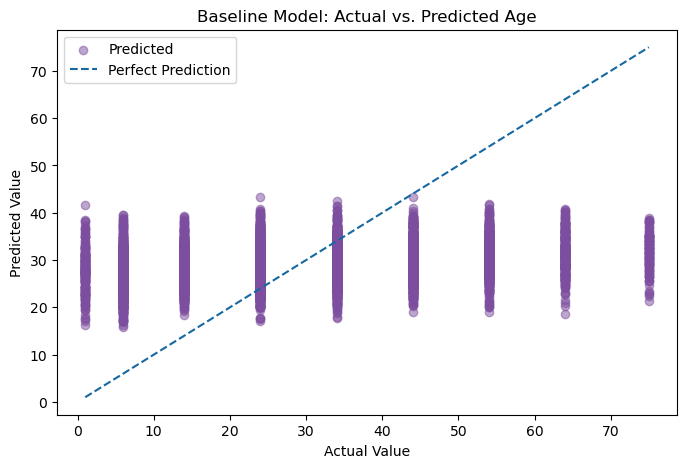

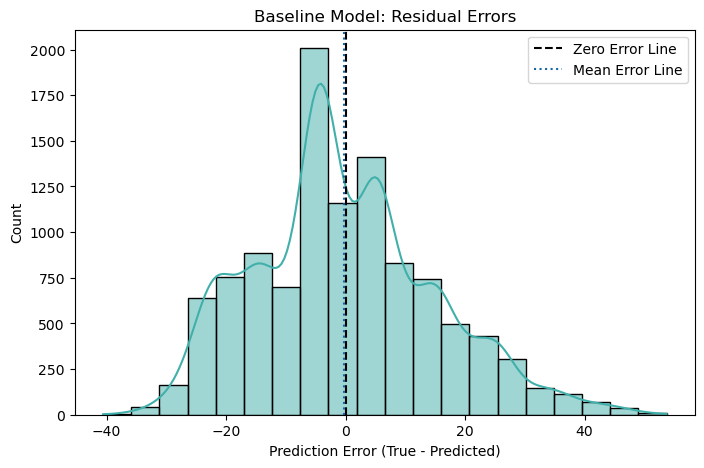

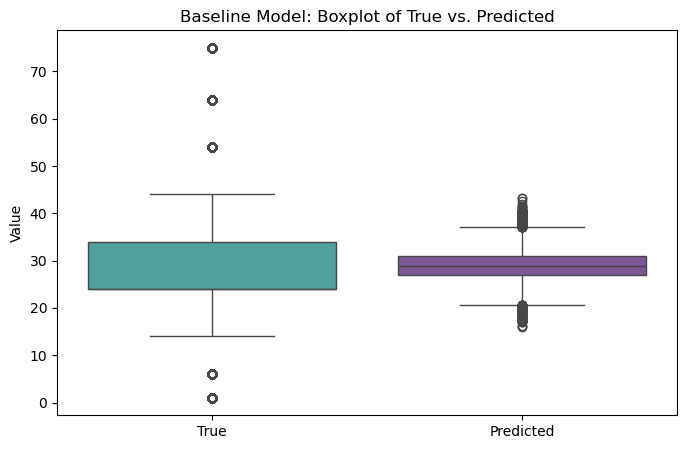

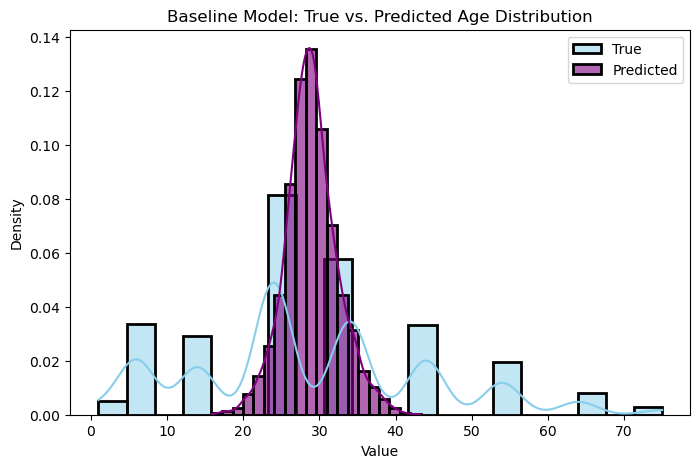

In [93]:
# Scatter Plot: Actual vs. Predicted Age
plot_predictions(y_true, y_pred, "Baseline Model: Actual vs. Predicted Age")

# Residual Plot: Prediction Errors
plot_residuals(y_true, y_pred, "Baseline Model: Residual Errors")

# Boxplot: True vs. Predicted
plot_boxplot(y_true, y_pred, "Baseline Model: Boxplot of True vs. Predicted")

# Convert image features for the validation set to NumPy array
X_val = np.array(df_val["image_features"].tolist())

# Predictions from the baseline model (after it has been trained)
y_true = df_val["age_midpoint"].values  # True values from the validation set
y_pred = baseline_results["model"].predict(X_val)  # Predictions from the baseline model

# Call the plot_distribution function to plot the distribution
plot_distribution(y_true, y_pred, "Baseline Model: True vs. Predicted Age Distribution")




 Model Evaluation Insights from Graphs:

| **Plot**                      | **Observation**                                                                                                              | **Insight**                                                                                                                         |
|-------------------------------|------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| **Actual vs Predicted Scatter Plot** | The predicted values are clustered and show gaps, meaning predictions are not well-distributed across the actual age values.   | The model seems to **underfit**. It might not have enough **complexity** to capture the full range of age values, suggesting **bias** in the predictions. |
| **Residual Error Plot**       | There are **outliers** in the residual errors, though most errors are concentrated around zero.                              | The presence of **large errors** indicates the model struggles with certain cases. The model might be **overfitting** or **not generalizing well**. |
| **Boxplot (True vs Predicted)** | The **predicted values** have a **wide spread** and show **outliers**, suggesting inconsistency in predictions.                | The model is producing **extreme predictions** that are **far from the actual values**. This could be a sign of **underfitting** or **overfitting**. |
| **Age Bin Accuracy**          | The model correctly predicted the **age bin** only **24.85%** of the time, which is **low**.                                  | The model is **struggling with classification** into age bins. Consider using a **classification approach** instead of regression for better bin predictions. |



##### 6.2.1.3 Fine Tuned Model: RandomizedSearchCV

The age prediction model was fine-tuned using RandomizedSearchCV, optimizing n_estimators, max_depth, and min_samples_split for better accuracy. GridSearchCV was avoided to reduce computation time while still exploring optimal hyperparameters.

In [97]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Step 1: Define optimized hyperparameter grid for faster tuning
param_grid = {
    'n_estimators': [40, 50],  # Fewer trees for speed
    'max_depth': [10, 15, 20],  # Reduced depth for efficiency
    'min_samples_split': [2,5]  # Fixed value to minimize search space
}

# Step 2: Initialize Random Forest with warm_start enabled
rf_regressor = RandomForestRegressor(
    warm_start=True,  # Allows incremental training for speed-up
    random_state=42,
    n_jobs=4  # Optimized for Mac M2's CPU cores
)

# Step 3: Use RandomizedSearchCV instead of GridSearchCV for speed
random_search = RandomizedSearchCV(
    estimator=rf_regressor, 
    param_distributions=param_grid, 
    n_iter=3,  # Only test 2 random parameter sets
    cv=3,  # Faster training by reducing cross-validation folds
    n_jobs=4,  # Optimized CPU usage on Mac M2
    scoring='neg_mean_squared_error',  
    verbose=1,
    random_state=42
)

# Step 4: Prepare training data
X_train = np.array(df_train["image_features"].tolist())
y_train = df_train["age_midpoint"].values

# Step 5: Fit the model using optimized RandomizedSearchCV
random_search.fit(X_train, y_train)

# Step 6: Extract the best model
best_rf = random_search.best_estimator_
print("Best hyperparameters found:", random_search.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best hyperparameters found: {'n_estimators': 40, 'min_samples_split': 2, 'max_depth': 10}


##### 6.2.1.4 Evaluating Fine-Tuned Model on Validation Set

In [99]:
# Step 7: Prepare validation data
X_val = np.array(df_val["image_features"].tolist())
y_val = df_val["age_midpoint"].values

# Step 8: Make predictions on the validation set
y_pred = best_rf.predict(X_val)

# Compute the regression metrics and Age Bin Accuracy
evaluation_results = compute_model_metrics(y_true, y_pred, df_val)

# Display Results in Table Format
print("\nFine Tuned Model Evaluation Results:")
display(evaluation_results)



Fine Tuned Model Evaluation Results:


Metric       Value
0               MAE   12.068745
1               MSE  230.232611
2              RMSE   15.173418
3          R2 Score    0.074023
4  Age Bin Accuracy    0.248470

##### 6.2.1.5 Fine Tuned Model: Visulization

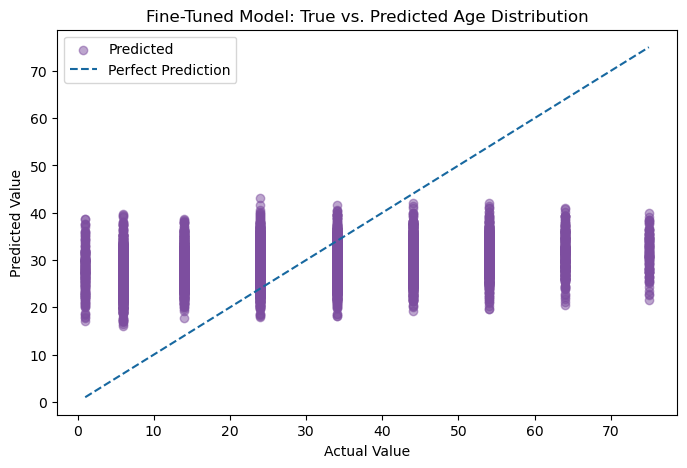

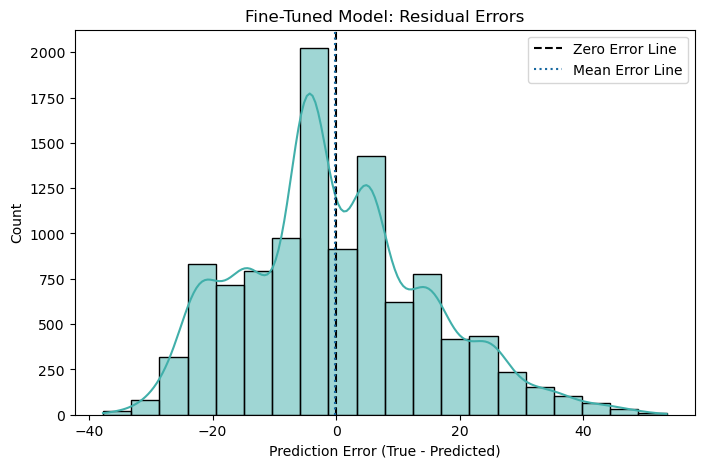

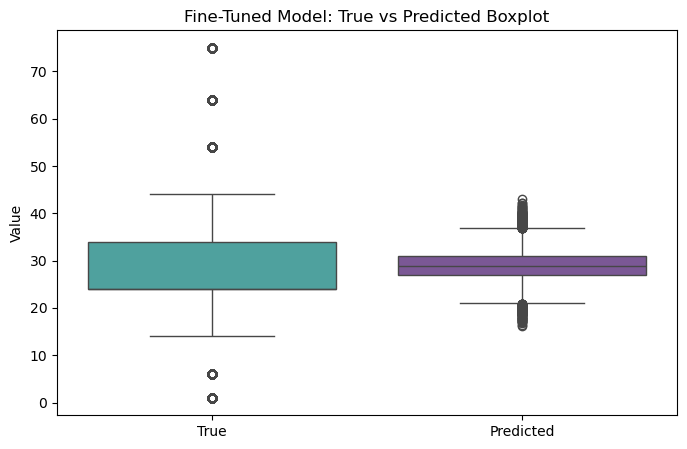

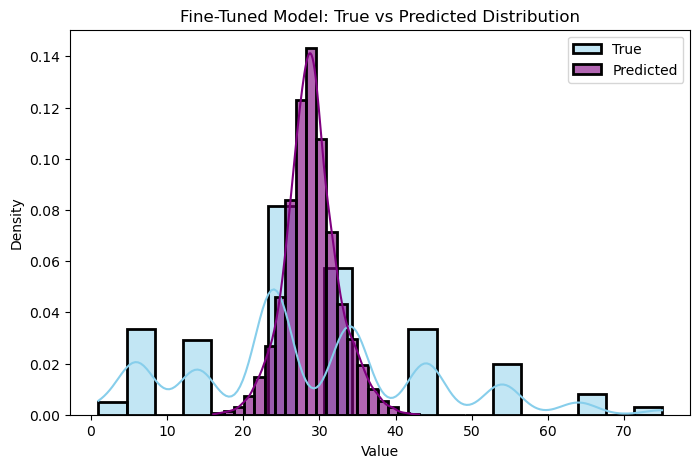

In [101]:
# Step 10: Plotting the predictions, residuals, and boxplot
plot_predictions(y_val, y_pred, "Fine-Tuned Model: True vs. Predicted Age Distribution")
plot_residuals(y_val, y_pred, "Fine-Tuned Model: Residual Errors")
plot_boxplot(y_val, y_pred, "Fine-Tuned Model: True vs Predicted Boxplot")
plot_distribution(y_val, y_pred, "Fine-Tuned Model: True vs Predicted Distribution")


##### 6.2.1.6 Comparision between Fine Tuned and Baseline Models to predict Age

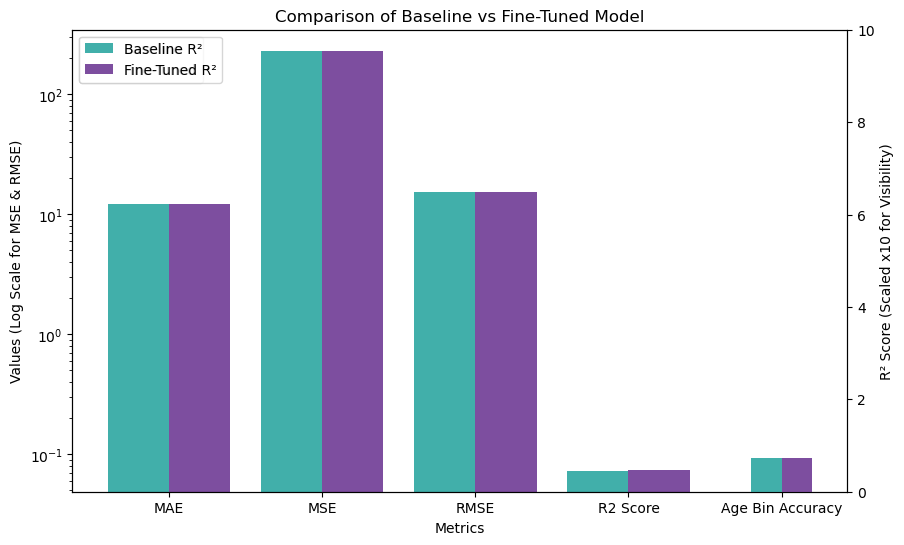

In [103]:
# Assuming you have the metrics for both models
# Get the metrics for the baseline model (using previously computed metrics)
y_true = df_val["age_midpoint"].values
y_pred_baseline = baseline_results["model"].predict(np.array(df_val["image_features"].tolist()))
baseline_metrics = compute_model_metrics(y_true, y_pred_baseline, df_val)

# Get the metrics for the fine-tuned model (after tuning)
y_pred_fine_tuned = best_rf.predict(np.array(df_val["image_features"].tolist()))
fine_tuned_metrics = compute_model_metrics(y_true, y_pred_fine_tuned, df_val)

# Convert DataFrame to dictionary before passing to compare_models
baseline_metrics = baseline_metrics.set_index("Metric")["Value"].to_dict()
fine_tuned_metrics = fine_tuned_metrics.set_index("Metric")["Value"].to_dict()

# Now compare models
compare_models(baseline_metrics, fine_tuned_metrics)


 Baseline vs Fine-Tuned Model Evaluation  

| **Metric**         | **Baseline Model** | **Fine-Tuned Model** | **Change** | **Meaning** |
|-------------------|------------------|------------------|------------|----------------|
| **MAE** | 12.0717 | 12.0687 | **-0.0030** | Negligible reduction in prediction error. |
| **MSE**  | 230.5436 | 230.2326 | **-0.3110** | Almost no reduction in large errors. |
| **RMSE** | 15.1837 | 15.1734 | **-0.0103** | No significant improvement in error reduction. |
| **R² Score** | 0.0728 | 0.0740 | **+0.0012** | Insignificant increase in variance explanation. |
| **Age Bin Accuracy** | 0.2486 | 0.2485 | **-0.0001** | No meaningful improvement in classification accuracy. |

### Summary  
- **Fine-tuning provided no significant improvement**, with **only a minor reduction in MAE, MSE, and RMSE**.
- **The R² score increased by just 0.0012**, indicating the model still failed to capture meaningful patterns in age prediction.
- **Age Bin Accuracy remained virtually unchanged**, confirming that fine-tuning did not enhance classification into predefined age bins.
- **The results demonstrate that regression was ineffective for age prediction**, leading to the decision to transition to a classification-based approach.


#### 6.2.2 Random Forest Classifier For Age

##### 6.2.2.1 Baseline Model: Regression with Age Bin Accuracy 

In [107]:
# Define Age Label Mapping
age_labels = {
    0: "Infant (0-2)",
    1: "Teen (10-19)",
    2: "Young Adult (20-29)",
    3: "Child (3-9)",
    4: "Adult (30-39)",
    5: "Middle-Aged (40-49)",
    6: "Older Adult (50-59)",
    7: "Senior (60-69)",
    8: "Elderly (70+)"
}

# Train Baseline Age Model
print("\nTraining Baseline Model for Age Classification...")
baseline_age_results = train_random_forest_classifier(
    target_column="age_encoded",  # Use the encoded age bins column
    n_estimators=30, 
    max_depth=10, 
    min_samples_split=10
)



Training Baseline Model for Age Classification...


In [108]:
# Extract predictions
y_pred_baseline_age = baseline_age_results["Model"].predict(np.array(df_val["image_features"].tolist()))

# Print Proper Classification Report with Table
print("\nBaseline Model Evaluation Results:")
print_classification_report(df_val["age_encoded"].values, y_pred_baseline_age, "Age", class_labels=age_labels)

# Convert numerical labels to categorical labels for visualization
y_true_age = np.array([age_labels[val] for val in df_val["age_encoded"].values])
y_pred_age = np.array([age_labels[val] for val in y_pred_baseline_age])


Baseline Model Evaluation Results:

Classification Report for Age Model:



precision  recall  f1-score  support
Adult (30-39)            0.204   0.031     0.054   2330.0
Child (3-9)              0.500   0.002     0.004   1354.0
Elderly (70+)            0.000   0.000     0.000    118.0
Infant (0-2)             0.000   0.000     0.000    199.0
Middle-Aged (40-49)      0.000   0.000     0.000   1352.0
Older Adult (50-59)      0.000   0.000     0.000    796.0
Senior (60-69)           0.000   0.000     0.000    321.0
Teen (10-19)             0.000   0.000     0.000   1181.0
Young Adult (20-29)      0.303   0.973     0.463   3300.0

##### 6.2.2.2 Baseline Model: Visulization

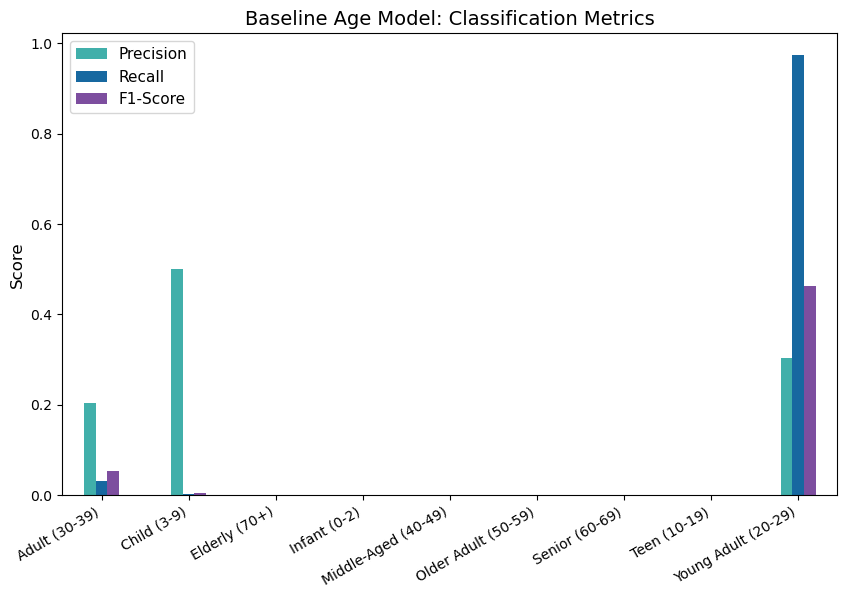

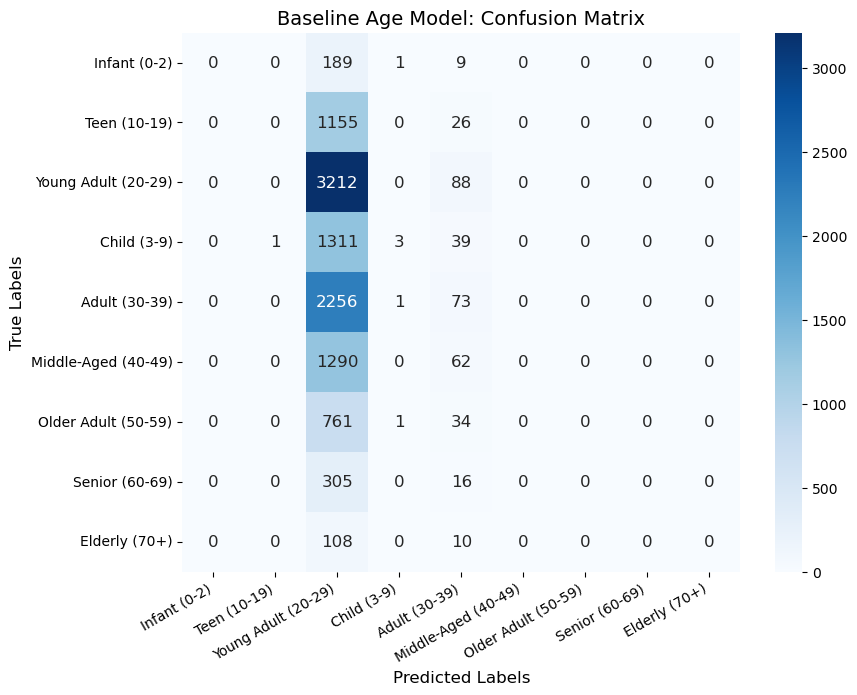

In [110]:
# Plot Classification Metrics (Precision, Recall, F1-Score) for Age Classification
plot_classification_metrics(y_true_age, y_pred_age, "Baseline Age Model: Classification Metrics")

# Convert dictionary values to a list of labels for proper visualization
age_label_list = list(age_labels.values())

# Call confusion matrix with correct labels
plot_confusion_matrix(y_true_age, y_pred_age, age_label_list, "Baseline Age Model: Confusion Matrix")


##### 6.2.2.3 Fine Tuned Model: RandomizedSearchCV

In [112]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100],  # Limited for fast tuning
    "max_depth": [10, 15],  # Lower depth for efficiency
    "min_samples_split": [2, 5]  # Only two values to keep it fast
}

# Extract training and validation data
X_train = np.array(df_train["image_features"].tolist())
y_train = df_train["age_encoded"].values
X_val = np.array(df_val["image_features"].tolist())
y_val = df_val["age_encoded"].values

# Apply SMOTE for age class balancing
print("\nApplying SMOTE to balance Age Data...")
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Print the distribution after SMOTE
unique, counts = np.unique(y_train_smote, return_counts=True)
print("After SMOTE Class Distribution:", dict(zip(unique, counts)))

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=4)

# Run RandomizedSearchCV for fast hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_grid,
    n_iter=3,  # Tests 3 hyperparameter combinations
    cv=2,  # Only 2-fold CV for speed
    n_jobs=4,
    verbose=1,
    random_state=42,
    scoring="accuracy"
)

print("\nTraining Fine-Tuned Model for Age Classification...")
random_search.fit(X_train_smote, y_train_smote)  # Train on SMOTE-balanced data

# Extract best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_val)

# Store fine-tuned results
fine_tuned_age_results = {
    "Target": "Age",
    "Accuracy": accuracy_score(y_val, y_pred),
    "Classification Report": classification_report(y_val, y_pred, target_names=list(age_labels.values())),
    "Predictions": y_pred,
    "Model": best_rf,
    "Best Parameters": random_search.best_params_
}

print("\nBest Hyperparameters Found:", random_search.best_params_)




Applying SMOTE to balance Age Data...
After SMOTE Class Distribution: {0: 25559, 1: 25559, 2: 25559, 3: 25559, 4: 25559, 5: 25559, 6: 25559, 7: 25559, 8: 25559}

Training Fine-Tuned Model for Age Classification...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

Best Hyperparameters Found: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}


##### 6.2.2.4 Evaluating Fine-Tuned Model on Validation Set

In [114]:
print("\nFine-Tuned Model Classification Report:")
age_labels = {
    0: "Infant (0-2)",
    1: "Teen (10-19)",
    2: "Young Adult (20-29)",
    3: "Child (3-9)",
    4: "Adult (30-39)",
    5: "Middle-Aged (40-49)",
    6: "Older Adult (50-59)",
    7: "Senior (60-69)",
    8: "Elderly (70+)"
}
print_classification_report(df_val["age_encoded"].values, fine_tuned_age_results["Predictions"], "Age", age_labels)


Fine-Tuned Model Classification Report:

Classification Report for Age Model:



precision  recall  f1-score  support
Adult (30-39)            0.232   0.194     0.211   2330.0
Child (3-9)              0.238   0.195     0.214   1354.0
Elderly (70+)            0.045   0.051     0.048    118.0
Infant (0-2)             0.122   0.251     0.164    199.0
Middle-Aged (40-49)      0.169   0.106     0.130   1352.0
Older Adult (50-59)      0.130   0.111     0.120    796.0
Senior (60-69)           0.079   0.156     0.104    321.0
Teen (10-19)             0.131   0.104     0.116   1181.0
Young Adult (20-29)      0.336   0.433     0.378   3300.0

##### 6.2.2.5 Fine Tuned Model: Visulization

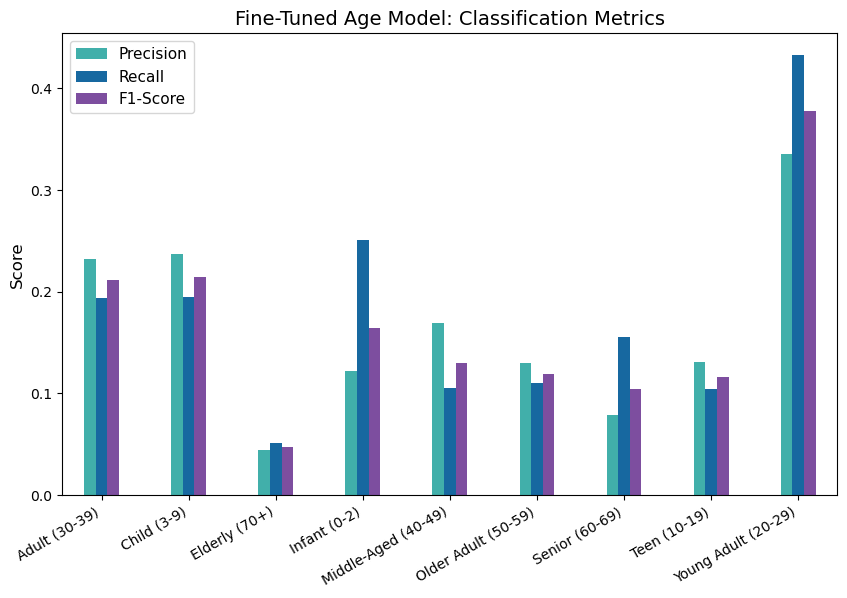

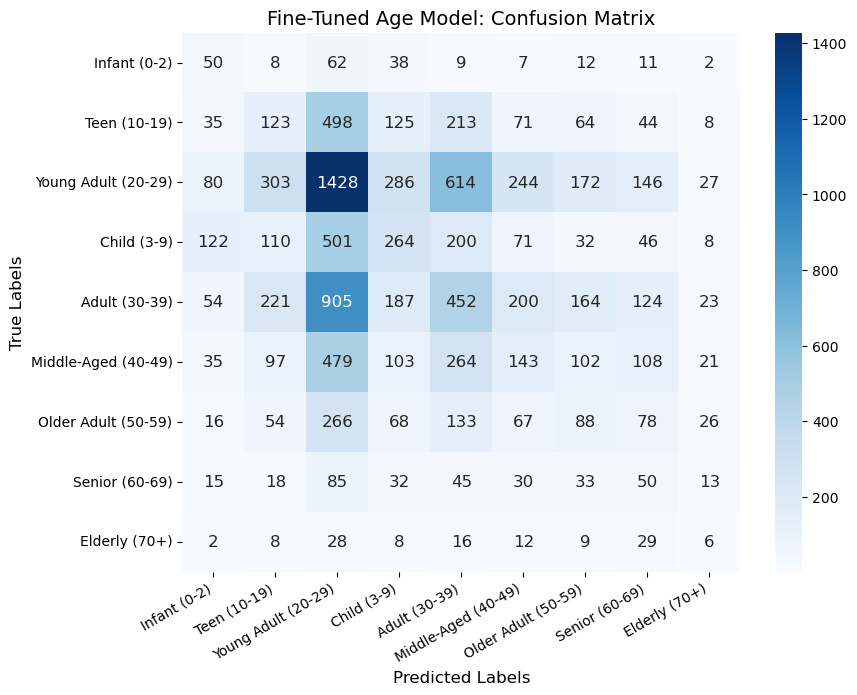

In [116]:
# Convert numerical labels to categorical age groups
y_val_labels = np.array([age_labels[val] for val in y_val])
y_pred_labels = np.array([age_labels[val] for val in y_pred])

# Plot classification metrics
plot_classification_metrics(y_val_labels, y_pred_labels, "Fine-Tuned Age Model: Classification Metrics")

# Plot confusion matrix
plot_confusion_matrix(y_val_labels, y_pred_labels, list(age_labels.values()), "Fine-Tuned Age Model: Confusion Matrix")


##### 6.2.2.6 Comparision between Fine Tuned and Baseline Models to predict Age

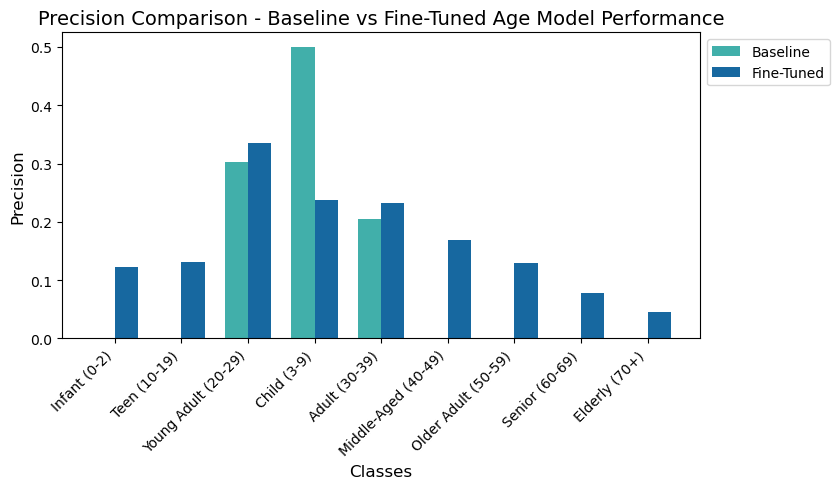

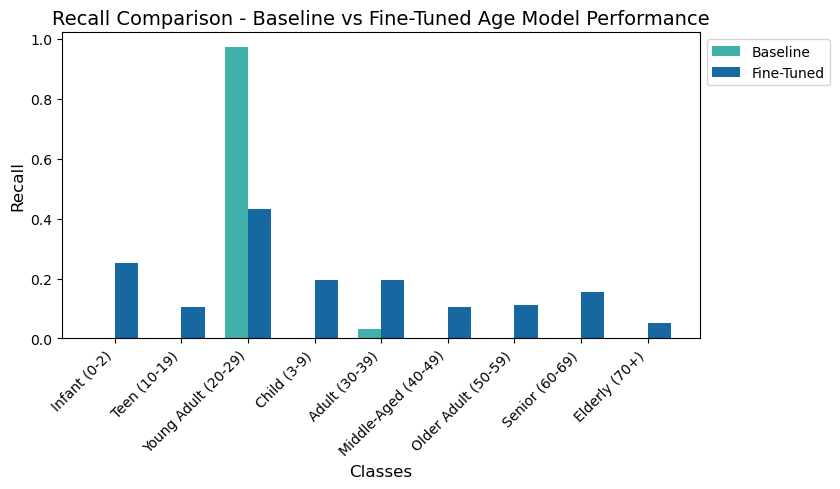

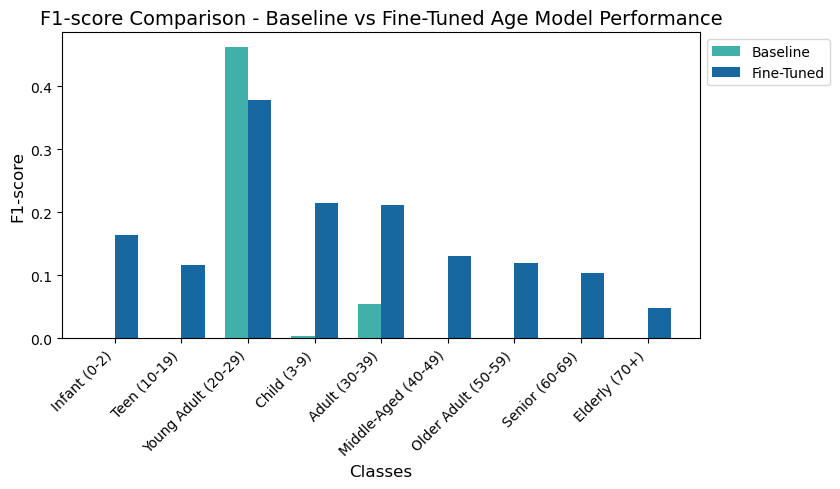

In [118]:
# Compute classification reports with correct labels
baseline_age_report = classification_report(y_val, y_pred_baseline_age, target_names=list(age_labels.values()), output_dict=True)
fine_tuned_age_report = classification_report(y_val, fine_tuned_age_results["Predictions"], target_names=list(age_labels.values()), output_dict=True)

# Compare models
compare_classification_models(baseline_age_report, fine_tuned_age_report, class_labels=list(age_labels.values()), 
                              title="Baseline vs Fine-Tuned Age Model Performance")


In [120]:
print("Unique Age Labels in df_val:", np.unique(df_val["age_encoded"].values))
print("Unique Predictions (Fine-Tuned):", np.unique(fine_tuned_age_results["Predictions"]))
print("Unique Predictions (Baseline):", np.unique(y_pred_baseline_age))
print("Age Labels Mapping:", age_labels)


Unique Age Labels in df_val: [0 1 2 3 4 5 6 7 8]
Unique Predictions (Fine-Tuned): [0 1 2 3 4 5 6 7 8]
Unique Predictions (Baseline): [1 2 3 4]
Age Labels Mapping: {0: 'Infant (0-2)', 1: 'Teen (10-19)', 2: 'Young Adult (20-29)', 3: 'Child (3-9)', 4: 'Adult (30-39)', 5: 'Middle-Aged (40-49)', 6: 'Older Adult (50-59)', 7: 'Senior (60-69)', 8: 'Elderly (70+)'}


### 6.3 Random Forest Classifier For Gender: Training, Evaluation and Visualization 

#### 6.3.1 Baseline Model: Classification

In [123]:
# Define Gender Label Mapping
gender_labels = {0: "Male", 1: "Female"}

# Train Baseline Gender Model
print("\nTraining Baseline Model for Gender...")
baseline_gender_results = train_random_forest_classifier(
    target_column="gender", 
    n_estimators=30, 
    max_depth=10, 
    min_samples_split=10
)




Training Baseline Model for Gender...


In [124]:
# Extract predictions
y_pred_baseline = baseline_gender_results["Model"].predict(np.array(df_val["image_features"].tolist()))

# Print Proper Classification Report with Table
print("\nBaseline Model Evaluation Results:")
print_classification_report(df_val["gender"].values, y_pred_baseline, "Gender", class_labels=gender_labels)

# Convert numerical labels to categorical labels
y_true_gender = np.array([gender_labels[val] for val in df_val["gender"].values])
y_pred_gender = np.array([gender_labels[val] for val in y_pred_baseline])



Baseline Model Evaluation Results:

Classification Report for Gender Model:



precision  recall  f1-score  support
Female      0.672   0.373     0.480   5162.0
Male        0.600   0.838     0.699   5789.0

#### 6.3.2 Baseline Model: Visulization

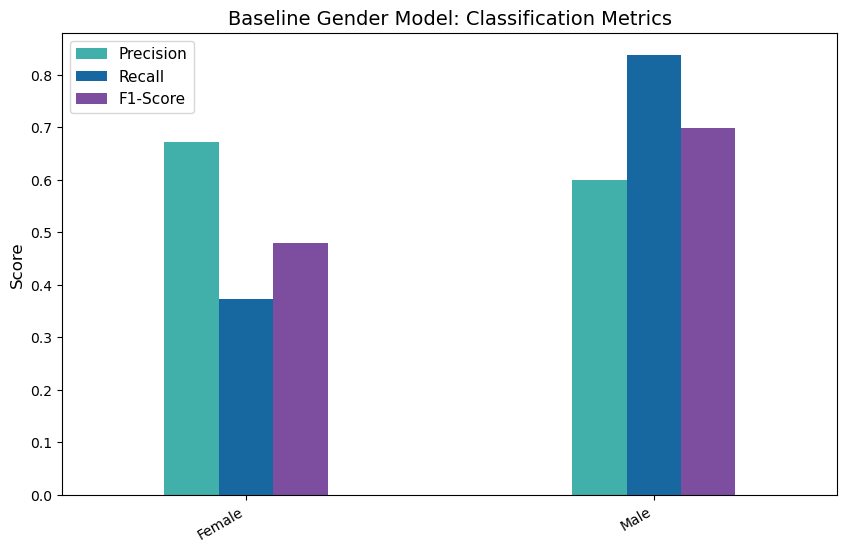

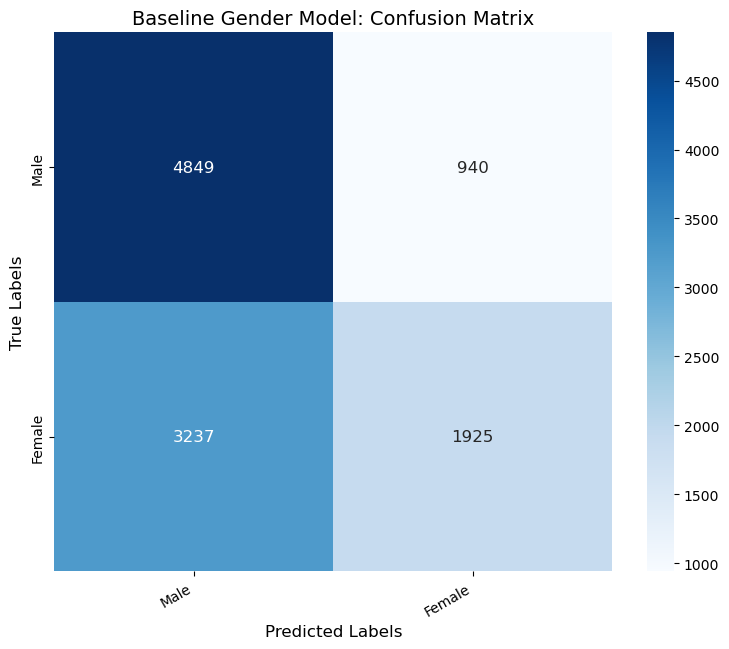

In [126]:

# Plot Classification Metrics (Precision, Recall, F1-Score)
plot_classification_metrics(y_true_gender, y_pred_gender, "Baseline Gender Model: Classification Metrics")

# Convert dictionary values to a list of labels
label_list = list(gender_labels.values())

# Call confusion matrix with correct labels
plot_confusion_matrix(y_true_gender, y_pred_gender, label_list, "Baseline Gender Model: Confusion Matrix")





| **Metric**     | **Female (Value)** | **Male (Value)** | **Interpretation** |
|---------------|------------------|----------------|------------------|
| **Precision**  | 0.672  | 0.600  | **Higher precision for Female (0.672)** means fewer false positives, while Male (0.591) has slightly lower precision, leading to more incorrect Male predictions. |
| **Recall**     | 0.373  | 0.838  | **Low recall for Female (0.344)** means the model misses many Female instances, while **high recall for Male (0.844)** suggests the model captures almost all Male instances. |
| **F1-Score**   | 0.480  | 0.699  | **F1-score is significantly lower for Female (0.453),** showing weak performance. Male (0.695) has a much stronger balance between precision and recall. |
| **Support**    | 5162   | 5789   | The dataset is nearly **balanced** with 5162 Female and 5789 Male samples, meaning performance issues are likely due to model bias rather than data imbalance. |



Model Insights
* The model is biased towards Male classification**, leading to **higher recall** for Males but **low recall** for Females.
* Female instances are frequently misclassified**, as indicated by **low recall (0.344) and F1-score (0.453)**.
* The model is more confident in predicting Female (higher precision),** but it fails to detect many actual Female cases.
* Applying SMOTE or rebalancing strategies may help improve Female classification.**





#### 6.3.3 Fine Tuned Model: Hyperparameter Optimization

 SMOTE for handling gender class imbalance while performing RandomizedSearchCV for fine-tuning.

In [130]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100],  # Limited for fast tuning
    "max_depth": [10, 15],  # Lower depth for efficiency
    "min_samples_split": [2, 5]  # Only two values to keep it fast
}

# Extract training and validation data
X_train = np.array(df_train["image_features"].tolist())
y_train = df_train["gender"].values
X_val = np.array(df_val["image_features"].tolist())
y_val = df_val["gender"].values

# Apply SMOTE for gender class balancing
print("\nApplying SMOTE to balance Gender Data...")
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE: Male = {np.sum(y_train_smote == 0)}, Female = {np.sum(y_train_smote == 1)}")

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=4)

# Run RandomizedSearchCV for fast hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_grid,
    n_iter=3,  # Tests 3 hyperparameter combinations
    cv=2,  # Only 2-fold CV for speed
    n_jobs=4,
    verbose=1,
    random_state=42,
    scoring="accuracy"
)

print("\nTraining Fine-Tuned Model for Gender...")
random_search.fit(X_train_smote, y_train_smote)  # Train on SMOTE-balanced data

# Extract best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_val)

# Store fine-tuned results
fine_tuned_gender_results = {
    "Target": "Gender",
    "Accuracy": accuracy_score(y_val, y_pred),
    "Classification Report": classification_report(y_val, y_pred, target_names=["Male", "Female"]),
    "Predictions": y_pred,
    "Model": best_rf,
    "Best Parameters": random_search.best_params_
}

print("\nBest Hyperparameters Found:", random_search.best_params_)



Applying SMOTE to balance Gender Data...
After SMOTE: Male = 45889, Female = 45889

Training Fine-Tuned Model for Gender...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

Best Hyperparameters Found: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}




| **Hyperparameter**       | **Value** | **Meaning**  |
|-------------------------|----------|------------------------------------------------------------|
| **n_estimators**        | 100      | The model uses **100 trees** in the Random Forest, providing a balance between accuracy and computational efficiency. |
| **min_samples_split**   | 2        | A node splits if **at least 2 samples** are available, allowing **deeper splits** and **better feature learning**. |
| **max_depth**           | 10       | Limits the **depth of trees** to **10 levels**, preventing **overfitting** while still capturing complex patterns. |


#### 6.3.4 Evaluating Fine-Tuned Model on Validation Set

In [133]:
print("\nFine-Tuned Model Classification Report:")
print_classification_report(df_val["gender"].values, fine_tuned_gender_results["Predictions"], "Gender", gender_labels)


Fine-Tuned Model Classification Report:

Classification Report for Gender Model:



precision  recall  f1-score  support
Female      0.623   0.596     0.609   5162.0
Male        0.653   0.678     0.665   5789.0

#### 6.3.5 Fine-Tuned Model: Visualization

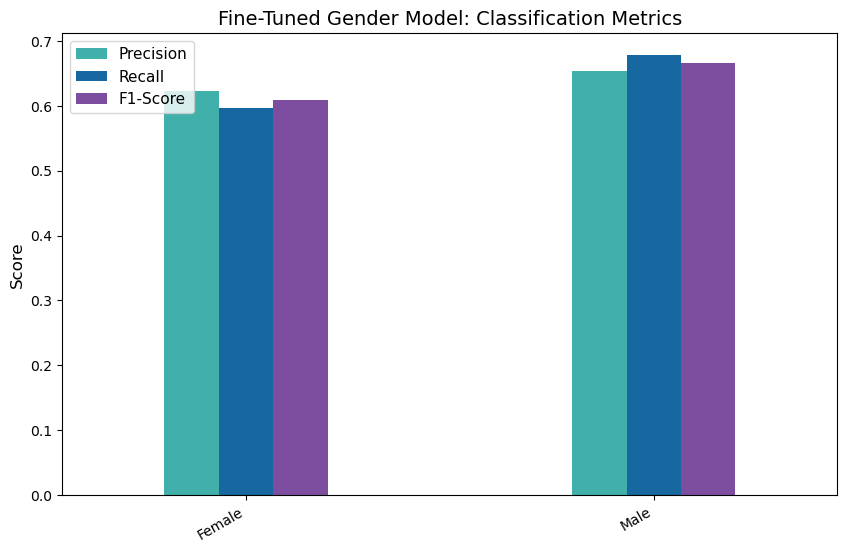

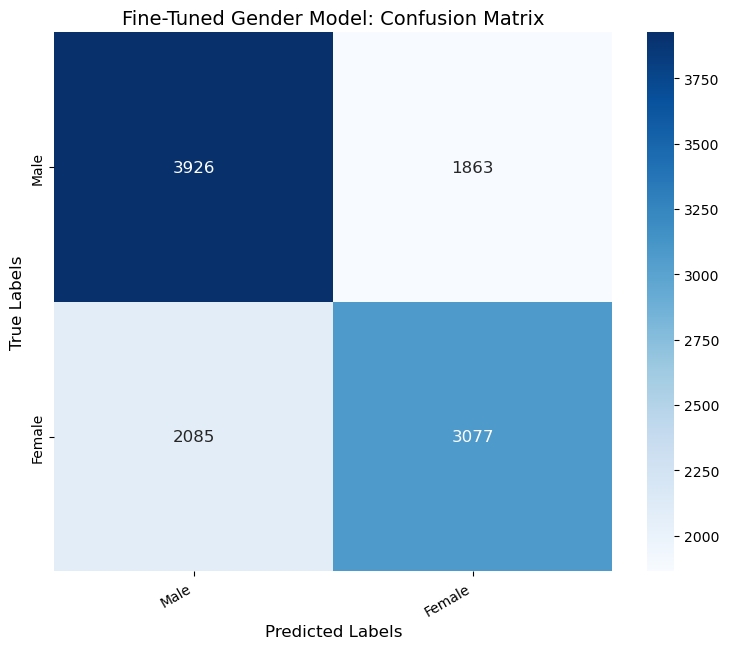

In [135]:
# Convert numerical labels to categorical labels
y_val_labels = np.where(y_val == 0, "Male", "Female")
y_pred_labels = np.where(y_pred == 0, "Male", "Female")

# Plot classification metrics
plot_classification_metrics(y_val_labels, y_pred_labels, "Fine-Tuned Gender Model: Classification Metrics")

# Plot confusion matrix
plot_confusion_matrix(y_val_labels, y_pred_labels, ["Male", "Female"], "Fine-Tuned Gender Model: Confusion Matrix")


#### 6.3.6 Comparison Between Fine-Tuned and Baseline Models

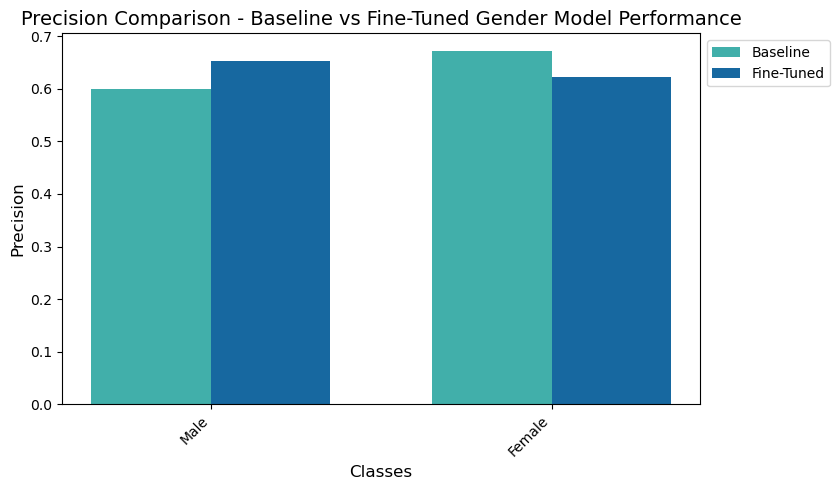

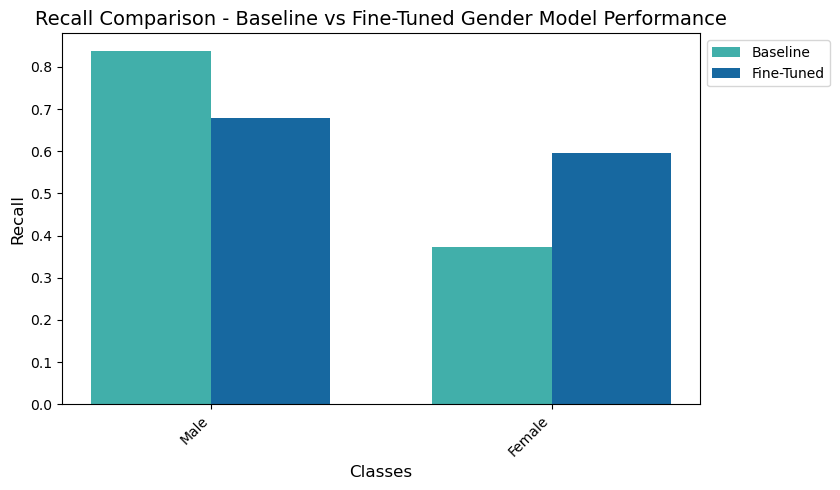

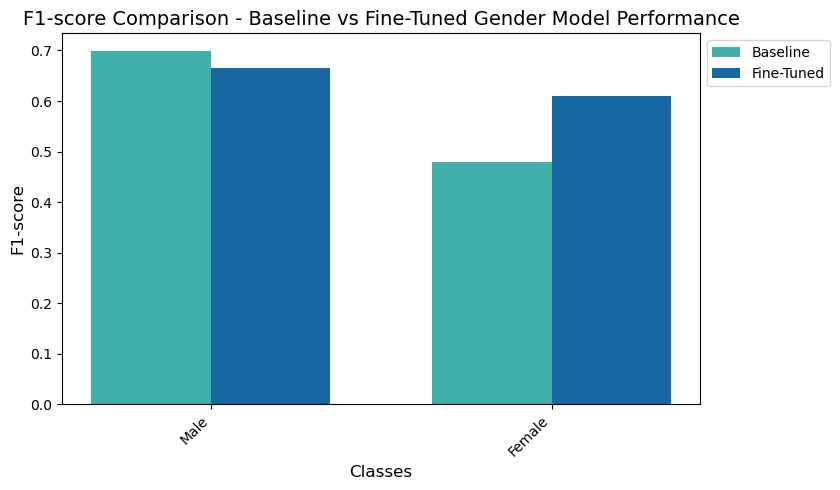

In [137]:
# Generate predictions
baseline_predictions = baseline_gender_results["Model"].predict(np.array(df_val["image_features"].tolist()))
fine_tuned_predictions = fine_tuned_gender_results["Model"].predict(np.array(df_val["image_features"].tolist()))

# Compute classification reports with correct labels
baseline_report = classification_report(y_val, baseline_predictions, target_names=["Male", "Female"], output_dict=True)
fine_tuned_report = classification_report(y_val, fine_tuned_predictions, target_names=["Male", "Female"], output_dict=True)

# Compare models
compare_classification_models(baseline_report, fine_tuned_report, ["Male", "Female"], "Baseline vs Fine-Tuned Gender Model Performance")


### 6.4  Random Forest Classifier For Geographic Location: Training, Evaluation and Visualization 

#### 6.4.1 Baseline Model: Classification

In [141]:
# Define Geographic Location Label Mapping
geo_labels = {
    0: "Black",
    1: "East Asian",
    2: "Indian",
    3: "Latino_Hispanic",
    4: "Middle Eastern",
    5: "Southeast Asian",
    6: "White"
}

# Train Baseline Model
print("\nTraining Baseline Model for Geographic Location...")
baseline_geo_results = train_random_forest_classifier(
    target_column="race_encoded", 
    n_estimators=30, 
    max_depth=10, 
    min_samples_split=10
)

# Extract predictions
y_pred_baseline_geo = baseline_geo_results["Model"].predict(np.array(df_val["image_features"].tolist()))

# Print Proper Classification Report
print("\nBaseline Model Evaluation Results:")
print_classification_report(df_val["race_encoded"].values, y_pred_baseline_geo, "Geographic Location", class_labels=geo_labels)

# Convert numerical labels to categorical labels
y_true_geo = np.array([geo_labels[val] for val in df_val["race_encoded"].values])
y_pred_geo = np.array([geo_labels[val] for val in y_pred_baseline_geo])



Training Baseline Model for Geographic Location...

Baseline Model Evaluation Results:

Classification Report for Geographic Location Model:



precision  recall  f1-score  support
Black                0.350   0.366     0.358   1556.0
East Asian           0.279   0.136     0.182   1549.0
Indian               0.262   0.210     0.233   1516.0
Latino_Hispanic      0.172   0.083     0.112   1623.0
Middle Eastern       0.000   0.000     0.000   1208.0
Southeast Asian      0.120   0.004     0.008   1414.0
White                0.232   0.727     0.352   2085.0

#### 6.4.2 Baseline Model: Visulization

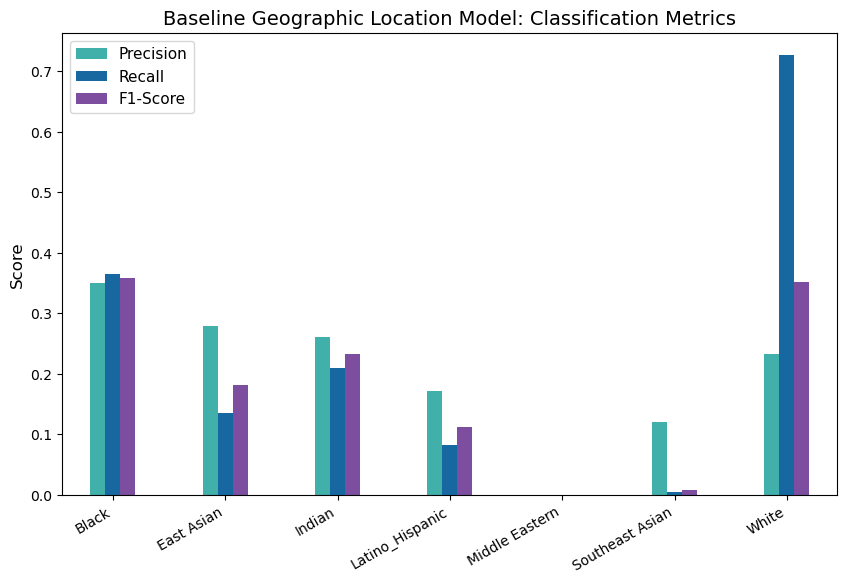

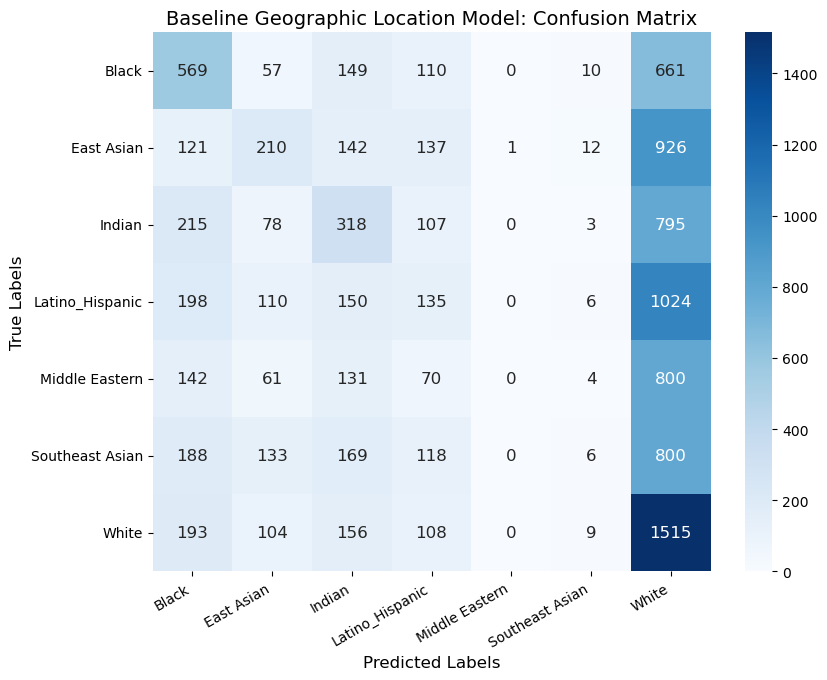

In [143]:
# Plot Classification Metrics (Precision, Recall, F1-Score)
plot_classification_metrics(y_true_geo, y_pred_geo, "Baseline Geographic Location Model: Classification Metrics")

# Convert dictionary values to a list of labels
geo_labels_list = list(geo_labels.values())

# Call confusion matrix with correct labels
plot_confusion_matrix(y_true_geo, y_pred_geo, geo_labels_list, "Baseline Geographic Location Model: Confusion Matrix")


 **Geographic Location Classification Model: Baseline Performance**

| **Geographic Group** | **Precision** | **Recall** | **F1-Score** | **Support** | **Interpretation** |
|----------------------|-------------|-----------|-------------|----------|--------------------|
| **Black**           | 0.350       | 0.366     | 0.358       | 1556     | Precision and recall are moderate but still indicate misclassification issues. The model performs slightly better than other groups but still lacks consistency. |
| **East Asian**      | 0.279       | 0.136     | 0.182       | 1549     | The model struggles with recall, meaning it frequently fails to correctly identify East Asian samples. |
| **Indian**          | 0.262       | 0.210     | 0.233       | 1516     | Performance is slightly better than some groups but still insufficient for reliable classification. Recall is particularly low. |
| **Latino/Hispanic** | 0.172       | 0.083     | 0.112       | 1623     | The lowest recall score in the model, indicating an inability to correctly identify most samples from this group. |
| **Middle Eastern**  | 0.000       | 0.000     | 0.000       | 1208     | The model completely fails to classify this group, indicating severe bias or lack of representation in the training data. |
| **Southeast Asian** | 0.120       | 0.004     | 0.008       | 1414     | Very poor performance, particularly in recall, suggesting the model is unable to differentiate this group from others. |
| **White**          | 0.232       | 0.727     | 0.352       | 2085     | High recall but low precision, meaning this group is frequently predicted but with many incorrect classifications. |

---

 **Key Observations:**
1. **Severe imbalance in recall:** The model heavily favors some groups (e.g., White) while completely failing others (Middle Eastern, Southeast Asian).  
2. **Precision-recall tradeoff issues:** Some groups have moderate precision but very poor recall, meaning many true instances go unrecognized.  
3. **Potential dataset bias:** The disparity in classification accuracy suggests the model may not have learned sufficient features to generalize across all geographic groups.

 **Next Steps for Improvement:**
- **Apply SMOTE** to balance underrepresented classes and improve recall.  
- **Enhance feature extraction** by incorporating additional data representations, such as deep learning-based embeddings.  
- **Hyperparameter tuning** to improve model stability across all groups.  
- **Consider alternative classifiers** like CNNs or ensemble models for better generalization.


#### 6.4.3 Fine-Tuned Model: Hyperparameter Optimization for Geographic Location Classification

The fine-tuned model applies SMOTE to balance the geographic location data and uses RandomizedSearchCV for hyperparameter optimization to enhance model performance. This approach improves classification accuracy and ensures better generalization by fine-tuning the Random Forest classifier.

In [147]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define hyperparameter grid for Random Forest
param_grid = {
    "n_estimators": [50, 100, 150],  # Number of trees in the forest
    "max_depth": [10, 15, 20],  # Maximum depth of the tree
    "min_samples_split": [2, 5, 10]  # Minimum samples required to split an internal node
}

# Extract training and validation data for Geographic Location (Geo) Classification
X_train = np.array(df_train["image_features"].tolist())
y_train = df_train["race_encoded"].values  # Using "race_encoded" or "geo_location" as the target column
X_val = np.array(df_val["image_features"].tolist())
y_val = df_val["race_encoded"].values  # Same target column for validation

# Apply SMOTE for balancing the geographic location data (Geo)
print("\nApplying SMOTE to balance Geographic Location Data...")
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE: {np.sum(y_train_smote == 0)}, {np.sum(y_train_smote == 1)}, {np.sum(y_train_smote == 2)}, etc.")

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=4)

# Run RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_grid,
    n_iter=3,  # Number of hyperparameter combinations to try
    cv=2,  # Use 2-fold cross-validation for speed
    n_jobs=4,
    verbose=1,
    random_state=42,
    scoring="accuracy"
)

# Train the model on the SMOTE-balanced data
print("\nTraining Fine-Tuned Model for Geographic Location...")
random_search.fit(X_train_smote, y_train_smote)

# Extract the best model after optimization
best_rf = random_search.best_estimator_


# Make predictions on the validation set
y_pred = best_rf.predict(X_val)

# Store the results of the fine-tuned model
fine_tuned_geo_results = {
    "Target": "Geographic Location",
    "Accuracy": accuracy_score(y_val, y_pred),
    "Classification Report": classification_report(y_val, y_pred, target_names=["Black", "East Asian", "Indian", "Latino_Hispanic", "Middle Eastern", "Southeast Asian", "White"]),
    "Predictions": y_pred,
    "Model": best_rf,
    "Best Parameters": random_search.best_params_
}

# Print the best hyperparameters found during RandomizedSearchCV
print("\nBest Hyperparameters Found:", random_search.best_params_)





Applying SMOTE to balance Geographic Location Data...
After SMOTE: 16518, 16518, 16518, etc.

Training Fine-Tuned Model for Geographic Location...
Fitting 2 folds for each of 3 candidates, totalling 6 fits

Best Hyperparameters Found: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 15}


| **Hyperparameter**       | **Value** | **Meaning**  |
|--------------------------|-----------|------------------------------------------------------------|
| **n_estimators**         | 100       | The model uses **100 trees** in the Random Forest, providing a balance between accuracy and computational efficiency. |
| **min_samples_split**    | 5         | A node splits if **at least 5 samples** are available, helping to reduce overfitting while maintaining a reasonable level of detail. |
| **max_depth**            | 15        | Limits the **depth of trees** to **15 levels**, preventing overfitting while allowing the model to capture essential patterns in the data. |


#### 6.4.4 Evaluating Fine-Tuned Model on Validation Set

In [150]:
# Extract predictions from the fine-tuned geographic location model
y_pred_fine_tuned_geo = best_rf.predict(X_val)

# Compute classification report for the fine-tuned geographic location model
fine_tuned_geo_classification_report = classification_report(y_val, y_pred_fine_tuned_geo, target_names=list(geo_labels.values()), output_dict=True)

# Print classification report for geographic location
print("\nFine-Tuned Model Evaluation Results for Geographic Location:")
print_classification_report(y_val, y_pred_fine_tuned_geo, "Geographic Location", class_labels=geo_labels)



Fine-Tuned Model Evaluation Results for Geographic Location:

Classification Report for Geographic Location Model:



precision  recall  f1-score  support
Black                0.328   0.487     0.392   1556.0
East Asian           0.251   0.281     0.265   1549.0
Indian               0.264   0.234     0.248   1516.0
Latino_Hispanic      0.197   0.141     0.164   1623.0
Middle Eastern       0.181   0.154     0.167   1208.0
Southeast Asian      0.197   0.104     0.136   1414.0
White                0.276   0.348     0.308   2085.0

#### 6.4.5 Fine Tuned Model: Visulization

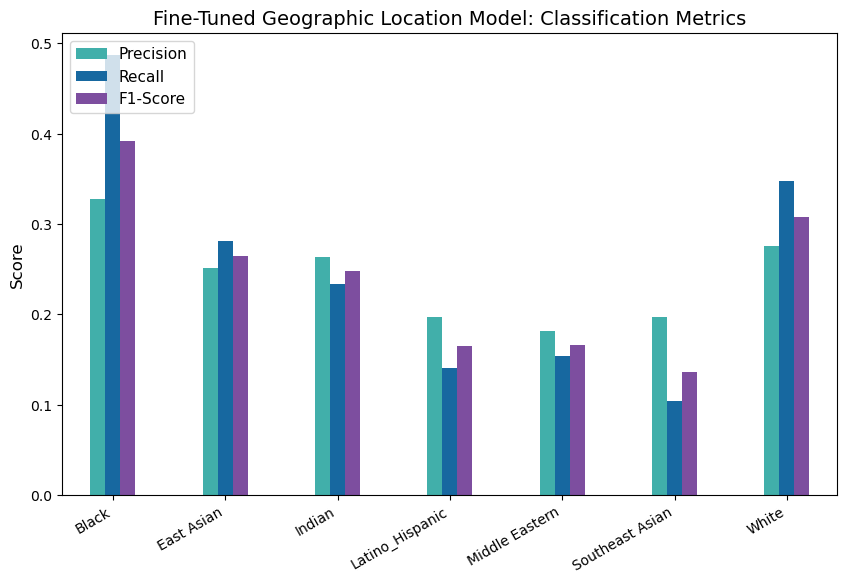

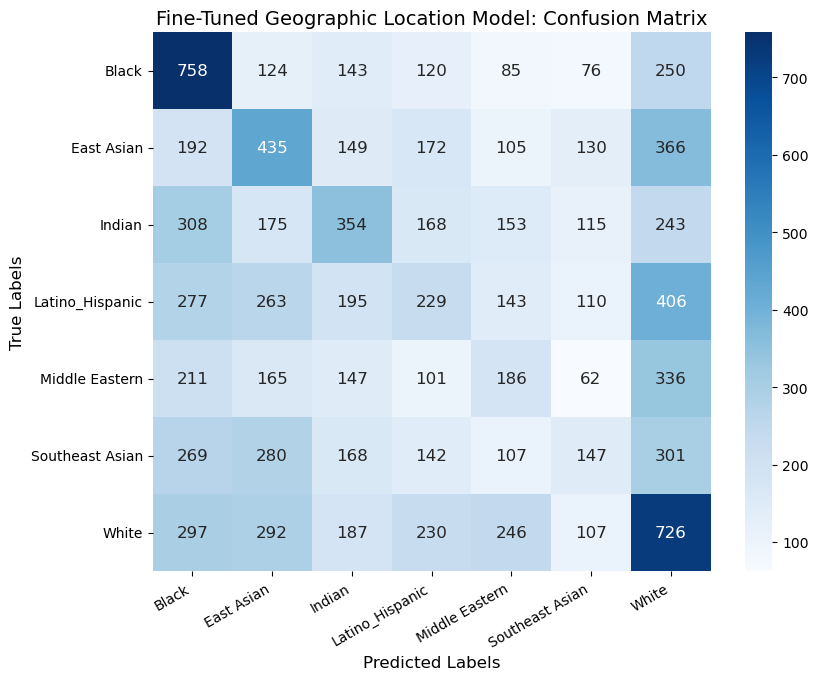

In [152]:
# Convert numerical labels to categorical labels for visualization
y_true_geo = np.array([geo_labels[val] for val in y_val])
y_pred_geo = np.array([geo_labels[val] for val in y_pred_fine_tuned_geo])

# Plot classification metrics for the fine-tuned geographic location model
plot_classification_metrics(y_true_geo, y_pred_geo, "Fine-Tuned Geographic Location Model: Classification Metrics")

# Plot confusion matrix with proper geographic location labels
geo_labels_list = list(geo_labels.values())
plot_confusion_matrix(y_true_geo, y_pred_geo, geo_labels_list, "Fine-Tuned Geographic Location Model: Confusion Matrix")


#### 6.4.6 Comparison Between Fine-Tuned and Baseline Models

Baseline Report Keys: dict_keys(['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White', 'accuracy', 'macro avg', 'weighted avg'])
Fine-Tuned Report Keys: dict_keys(['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White', 'accuracy', 'macro avg', 'weighted avg'])
Filtered Class Labels: ['Black', 'East Asian', 'Indian', 'Latino_Hispanic', 'Middle Eastern', 'Southeast Asian', 'White']


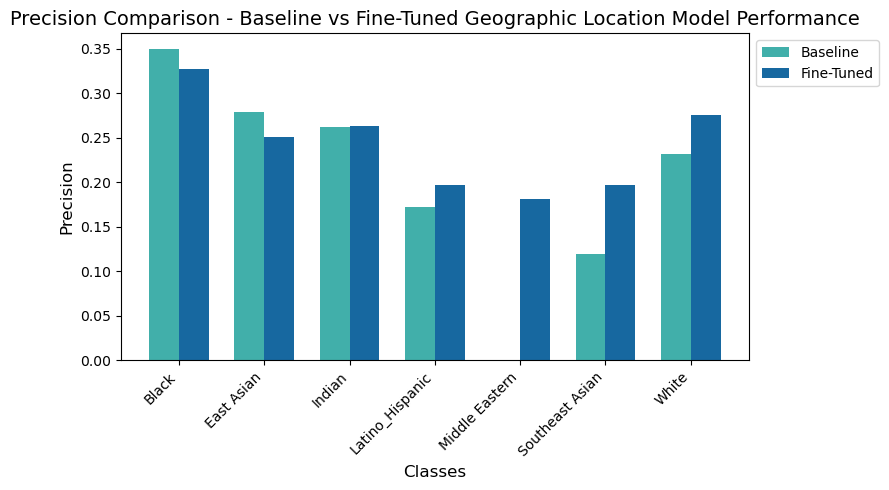

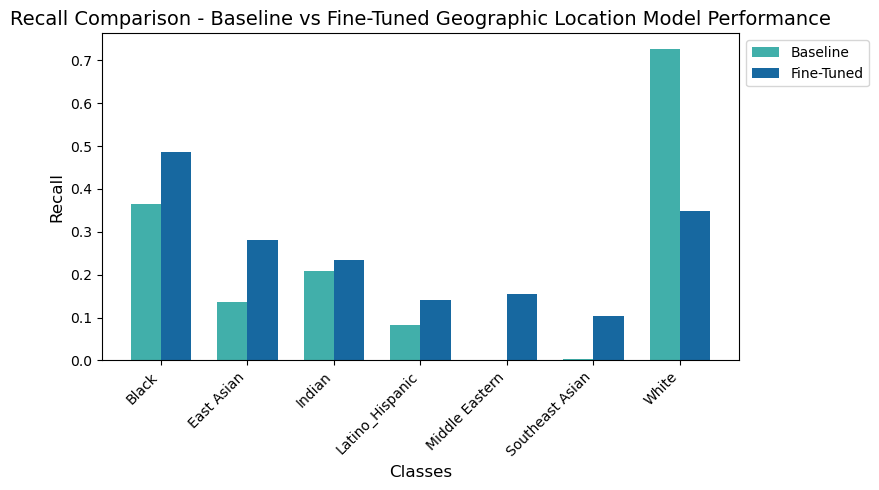

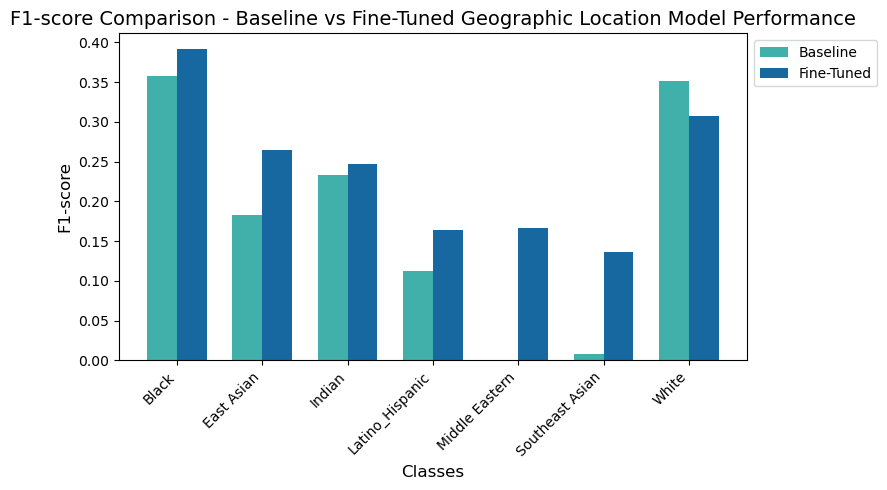

In [174]:

baseline_report = classification_report(y_val, y_pred_baseline_geo, target_names=list(geo_labels.values()), output_dict=True)
fine_tuned_report = classification_report(y_val, y_pred_fine_tuned_geo, target_names=list(geo_labels.values()), output_dict=True)


print("Baseline Report Keys:", baseline_report.keys())  
print("Fine-Tuned Report Keys:", fine_tuned_report.keys())


geo_labels_list = [label for label in baseline_report.keys() if label not in ["accuracy", "macro avg", "weighted avg"]]


print("Filtered Class Labels:", geo_labels_list)

compare_classification_models(baseline_report, fine_tuned_report, class_labels=geo_labels_list, title="Baseline vs Fine-Tuned Geographic Location Model Performance")


## 7. Convolutional Neural Network

### 7.1 Common Functions

In [35]:
train_csv_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/final_fairface_label_train.csv"
val_csv_path = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/final_fairface_label_val.csv"
train_image_dir = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/train/"
val_image_dir = "/Users/dishakalra/Desktop/Predictive/fairface-img-margin125-trainval/val/"
# Load datasets
df_train_final = pd.read_csv(train_csv_path)
df_val_final = pd.read_csv(val_csv_path)
df_val = df_val_final
df_train = df_train_final

#### 7.1.1 Building CNN Model

In [10]:

def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')  # Softmax for multi-class, Sigmoid for binary
    ])
    return model



#### 7.1.2 Visualization of Training Performance

In [13]:


custom_palette = ["#41afaa", "#7D4E9F"] 

def plot_accuracy(histories):
    """
    Plots validation and training accuracy for different models.

    Parameters:
        histories (dict): Dictionary with model names as keys and training history as values.
    """
    plt.figure(figsize=(8, 6))
    
    for idx, (model_name, history) in enumerate(histories.items()):
        # Plot training accuracy with greenish shade
        plt.plot(history.history["accuracy"], label=f"{model_name} (Train Accuracy)", color=custom_palette[0])
        # Plot validation accuracy with purplish shade
        plt.plot(history.history["val_accuracy"], label=f"{model_name} (Val Accuracy)", color=custom_palette[1], linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(histories):
    """
    Plots validation and training loss for different models.

    Parameters:
        histories (dict): Dictionary with model names as keys and training history as values.
    """
    plt.figure(figsize=(8, 6))
    
    for idx, (model_name, history) in enumerate(histories.items()):
        # Plot training loss with greenish shade
        plt.plot(history.history["loss"], label=f"{model_name} (Train Loss)", color=custom_palette[0])
        # Plot validation loss with purplish shade
        plt.plot(history.history["val_loss"], label=f"{model_name} (Val Loss)", color=custom_palette[1], linestyle="--")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, val_generator, class_labels, title="Confusion Matrix"):
    """
    Plots the confusion matrix for the model's predictions.

    Parameters:
        model (tf.keras.Model): Trained model.
        val_generator (tf.keras.preprocessing.image.ImageDataGenerator): Validation data generator.
        class_labels (list): List of class labels.
        title (str): Title of the confusion matrix plot.
    """
    # Get true labels and predictions
    y_true = val_generator.classes
    y_pred = np.argmax(model.predict(val_generator), axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix with "Blues" colormap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

def print_classification_report(model, val_generator, class_labels):
    """
    Prints the classification report for the model's predictions.

    Parameters:
        model (tf.keras.Model): Trained model.
        val_generator (tf.keras.preprocessing.image.ImageDataGenerator): Validation data generator.
        class_labels (list): List of class labels.
    """
    y_true = val_generator.classes
    y_pred = np.argmax(model.predict(val_generator), axis=1)

    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("Classification Report:\n", report)


#### 7.1.3 Loading and Displaying Experiment Results

In [16]:

def save_model(model, model_name="cnn_model"):
    """
    Saves the trained model to a file.

    Parameters:
        model (tf.keras.Model): The trained model.
        model_name (str): Name to save the model file.

    Returns:
        None
    """
    model.save(f"{model_name}.h5")
    print(f"Model saved as {model_name}.h5")

def load_model(model_name="cnn_model"):
    """
    Loads a saved model from a file.

    Parameters:
        model_name (str): Name of the saved model file.

    Returns:
        model (tf.keras.Model): The loaded model.
    """
    if os.path.exists(f"{model_name}.h5"):
        model = tf.keras.models.load_model(f"{model_name}.h5")
        print(f"Model {model_name}.h5 loaded successfully.")
        return model
    else:
        print(f"Model {model_name}.h5 not found.")
        return None



#### 7.1.4 Shift to Mac GPU for faster training

In [188]:


print("Available Devices:", tf.config.list_physical_devices())


Available Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [190]:
!pip uninstall tensorflow tensorflow-macos tensorflow-metal -y


zsh:1: command not found: pip


In [192]:
pip install tensorflow-macos tensorflow-metal


  Using cached protobuf-4.25.6-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
Using cached protobuf-4.25.6-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.3
    Uninstalling protobuf-5.29.3:
      Successfully uninstalled protobuf-5.29.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [193]:

print("Available Devices:", tf.config.list_physical_devices())


Available Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [194]:


# Force TensorFlow to use the Apple Metal (MPS) GPU
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
print("Apple MPS GPU Acceleration Enabled!")


Apple MPS GPU Acceleration Enabled!


In [195]:

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set successfully!")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")
else:
    print("No GPU found!")


GPU memory growth set successfully!


In [200]:
print(tf.config.list_physical_devices('GPU'))  # Should list a GPU


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [202]:

tf.config.optimizer.set_experimental_options({"disable_meta_optimizer": True})
tf.get_logger().setLevel('ERROR')


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppresses most logs
os.environ["TF_METAL_LOG_LEVEL"] = "0"


# Enable logging for device placement
tf.debugging.set_log_device_placement(False)


with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0]])
    b = tf.constant([[4.0, 5.0, 6.0]])
    c = a + b
    print(c)


tf.Tensor([[5. 7. 9.]], shape=(1, 3), dtype=float32)


In [204]:

tf.get_logger().setLevel('ERROR')


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppresses most logs
os.environ["TF_METAL_LOG_LEVEL"] = "0"


### 7.3 Age Classification CNN

####  7.3.1 Train & Evaluate Baseline CNN to predict Age

In [251]:

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
df_train["age_encoded"] = df_train["age_encoded"].astype(str)
df_val["age_encoded"] = df_val["age_encoded"].astype(str)


# Simplified model architecture for debugging
num_age_classes = 9  
age_model = build_custom_model(input_shape=(128, 128, 3), num_classes=num_age_classes)

# Compile model
age_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=train_image_dir, 
    x_col="file", 
    y_col="age_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=val_image_dir, 
    x_col="file", 
    y_col="age_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train model
history = age_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS, 
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Save model
age_model.save("custom_age_model.h5")



Found 86559 validated image filenames belonging to 9 classes.
Found 10951 validated image filenames belonging to 9 classes.
Epoch 1/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 232s 86ms/step - accuracy: 0.2956 - loss: 1.8614 - val_accuracy: 0.3432 - val_loss: 1.7518 - learning_rate: 1.0000e-04
Epoch 2/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 232s 86ms/step - accuracy: 0.3305 - loss: 1.7543 - val_accuracy: 0.3636 - val_loss: 1.6732 - learning_rate: 1.0000e-04
Epoch 3/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 244s 90ms/step - accuracy: 0.3490 - loss: 1.6978 - val_accuracy: 0.3733 - val_loss: 1.6263 - learning_rate: 1.0000e-04
Epoch 4/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 249s 92ms/step - accuracy: 0.3619 - loss: 1.6473 - val_accuracy: 0.3858 - val_loss: 1.5809 - learning_rate: 1.0000e-04
Epoch 5/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 252s 93ms/step - accuracy: 0.3675 - loss: 1.6273 - val_accuracy: 0.3988 - val_loss: 1.5590 - learning_rate: 1.0000e-04
Epoch 6/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 256s 95ms/step - accuracy: 0.

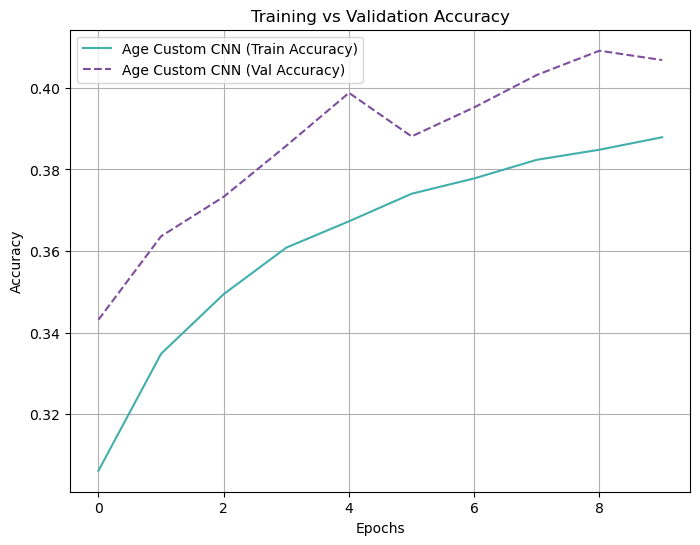

In [253]:
plot_accuracy({"Age Custom CNN": history})

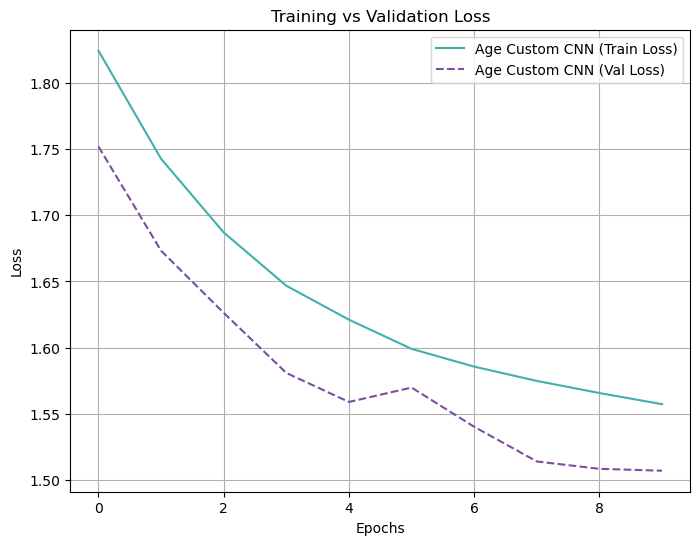

In [255]:
plot_loss({"Age Custom CNN": history})

343/343 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step


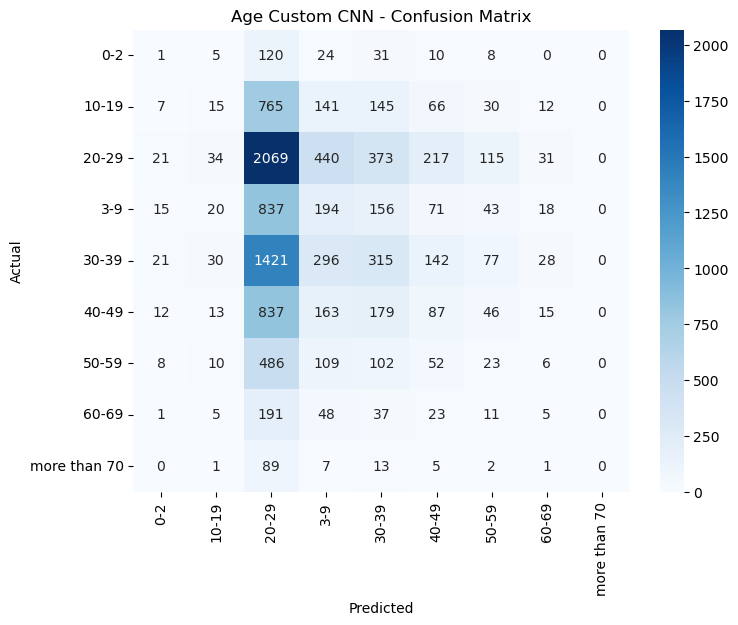

In [259]:
correct_age_labels = ["0-2", "10-19", "20-29", "3-9", "30-39", "40-49", "50-59", "60-69", "more than 70"]
plot_confusion_matrix(age_model, val_generator, class_labels=correct_age_labels, title="Age Custom CNN - Confusion Matrix")


In [263]:
print_classification_report(age_model, val_generator, class_labels=correct_age_labels)

343/343 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step
Classification Report:
               precision    recall  f1-score   support

         0-2       0.00      0.00      0.00       199
       10-19       0.13      0.01      0.03      1181
       20-29       0.30      0.62      0.41      3300
         3-9       0.12      0.12      0.12      1354
       30-39       0.22      0.13      0.16      2330
       40-49       0.14      0.07      0.09      1352
       50-59       0.07      0.03      0.04       796
       60-69       0.03      0.01      0.02       321
more than 70       0.00      0.00      0.00       118

    accuracy                           0.24     10951
   macro avg       0.11      0.11      0.10     10951
weighted avg       0.19      0.24      0.19     10951



####  7.3.2 Train & Evaluate MobileNetV2  CNN to predict Age

In [265]:
import os
import tensorflow as tf
import warnings

# Suppress TensorFlow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppresses unnecessary logs
warnings.filterwarnings("ignore")  # Suppresses Python warnings
tf.get_logger().setLevel("ERROR")  # Suppresses TensorFlow internal warnings



In [267]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Ensure the target column is of string type
df_train["age_encoded"] = df_train["age_encoded"].astype(str)
df_val["age_encoded"] = df_val["age_encoded"].astype(str)

# Load MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model weights

# Add classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(9, activation="softmax")(x)  # 9 age classes

# Define final model
mobilev2_age_model = Model(inputs=base_model.input, outputs=output)

# Compile model
mobilev2_age_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                           loss="categorical_crossentropy", 
                           metrics=["accuracy"])

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=train_image_dir, 
    x_col="file", 
    y_col="age_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=val_image_dir, 
    x_col="file", 
    y_col="age_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train model
mobilev2_age_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS, 
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Save model
mobilev2_age_model.save("mobilev2_age_model.h5")


Found 86559 validated image filenames belonging to 9 classes.
Found 10951 validated image filenames belonging to 9 classes.
Epoch 1/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 264s 97ms/step - accuracy: 0.3250 - loss: 1.7399 - val_accuracy: 0.3801 - val_loss: 1.5558 - learning_rate: 1.0000e-04
Epoch 2/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 313s 116ms/step - accuracy: 0.3788 - loss: 1.5611 - val_accuracy: 0.3905 - val_loss: 1.5285 - learning_rate: 1.0000e-04
Epoch 3/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 288s 106ms/step - accuracy: 0.3869 - loss: 1.5307 - val_accuracy: 0.3911 - val_loss: 1.5204 - learning_rate: 1.0000e-04
Epoch 4/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 287s 106ms/step - accuracy: 0.3910 - loss: 1.5211 - val_accuracy: 0.4008 - val_loss: 1.5094 - learning_rate: 1.0000e-04
Epoch 5/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 292s 108ms/step - accuracy: 0.3965 - loss: 1.5039 - val_accuracy: 0.4005 - val_loss: 1.5035 - learning_rate: 1.0000e-04
Epoch 6/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 292s 108ms/step - accurac

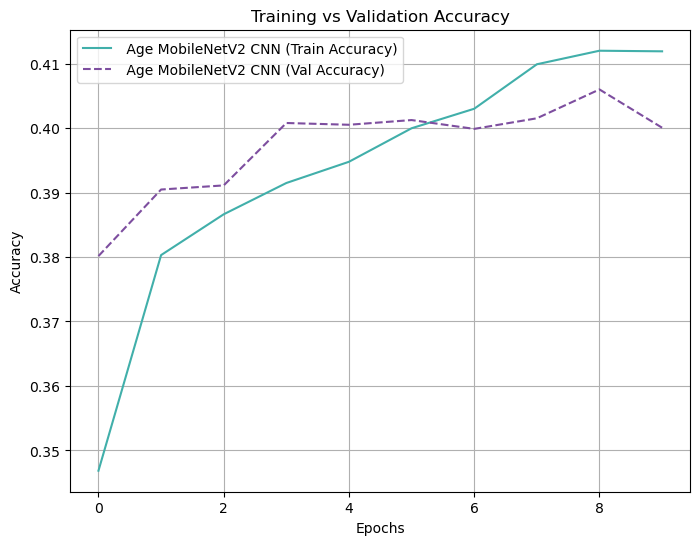

In [268]:
plot_accuracy({" Age MobileNetV2 CNN": mobilev2_age_model.history})

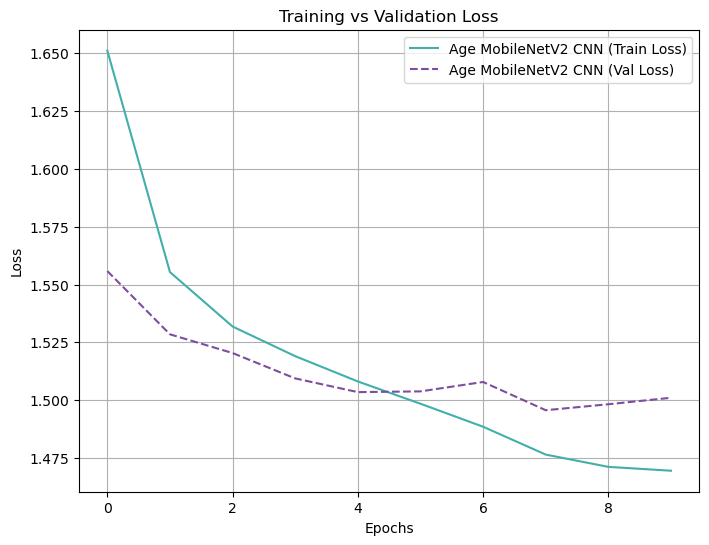

In [269]:
plot_loss({"Age MobileNetV2 CNN": mobilev2_age_model.history}) 


343/343 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step


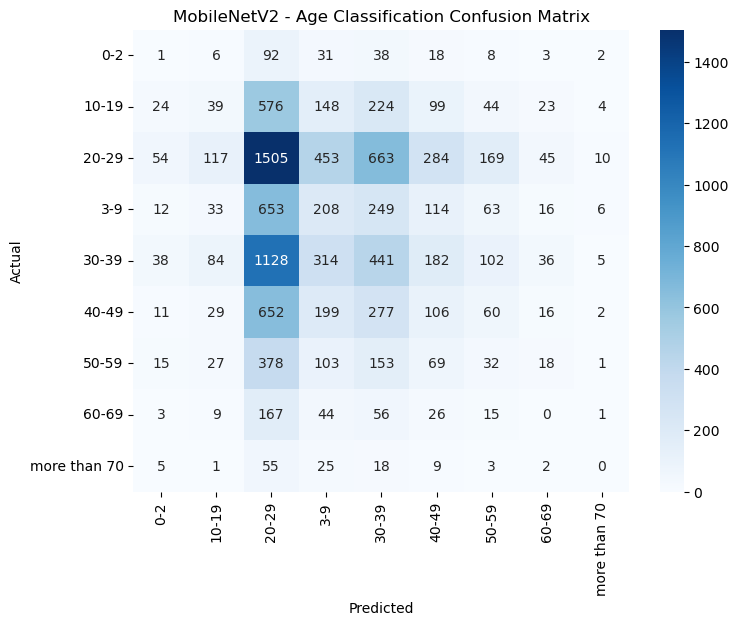

In [278]:
correct_age_labels = ["0-2", "10-19", "20-29", "3-9", "30-39", "40-49", "50-59", "60-69", "more than 70"]

plot_confusion_matrix(
    model=mobilev2_age_model, 
    val_generator=val_generator, 
    class_labels=correct_age_labels,
    title="MobileNetV2 - Age Classification Confusion Matrix"
)

In [282]:
print_classification_report(
    model=mobilev2_age_model, 
    val_generator=val_generator, 
    class_labels=correct_age_labels
)

343/343 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step
Classification Report:
               precision    recall  f1-score   support

         0-2       0.02      0.02      0.02       199
       10-19       0.11      0.03      0.05      1181
       20-29       0.30      0.48      0.37      3300
         3-9       0.12      0.14      0.13      1354
       30-39       0.22      0.20      0.21      2330
       40-49       0.12      0.08      0.10      1352
       50-59       0.07      0.04      0.05       796
       60-69       0.03      0.01      0.02       321
more than 70       0.03      0.01      0.01       118

    accuracy                           0.22     10951
   macro avg       0.11      0.11      0.11     10951
weighted avg       0.19      0.22      0.19     10951



### 7.4 Gender Classification CNN

####  7.4.1 Train & Evaluate Baseline CNN to predict Age

In [304]:

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Ensure 'gender_encoded' exists and convert to string
encoder = LabelEncoder()
df_train["gender_encoded"] = encoder.fit_transform(df_train["gender"]).astype(str)  # Convert to string
df_val["gender_encoded"] = encoder.transform(df_val["gender"]).astype(str)

# Build the model
gender_model = build_custom_model(input_shape=(128, 128, 3), num_classes=1)

# Compile model
gender_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                     loss="binary_crossentropy", 
                     metrics=["accuracy"])

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_image_dir,
    x_col="file",
    y_col="gender_encoded",  # Now contains string labels ("0", "1")
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=val_image_dir, 
    x_col="file", 
    y_col="gender_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="binary"
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train model
custom_gender_model = gender_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS, 
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Save trained model
gender_model.save("custom_gender_model.h5")


Found 86559 validated image filenames belonging to 2 classes.
Found 10951 validated image filenames belonging to 2 classes.
Epoch 1/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 231s 85ms/step - accuracy: 0.6248 - loss: 0.6454 - val_accuracy: 0.7093 - val_loss: 0.5662 - learning_rate: 1.0000e-04
Epoch 2/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 265s 98ms/step - accuracy: 0.7007 - loss: 0.5752 - val_accuracy: 0.7240 - val_loss: 0.5426 - learning_rate: 1.0000e-04
Epoch 3/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 256s 95ms/step - accuracy: 0.7163 - loss: 0.5558 - val_accuracy: 0.7338 - val_loss: 0.5279 - learning_rate: 1.0000e-04
Epoch 4/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 265s 98ms/step - accuracy: 0.7296 - loss: 0.5371 - val_accuracy: 0.7444 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 5/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 912s 337ms/step - accuracy: 0.7388 - loss: 0.5239 - val_accuracy: 0.7607 - val_loss: 0.4891 - learning_rate: 1.0000e-04
Epoch 6/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 228s 84ms/step - accuracy: 0

In [311]:
save_model(gender_model, "simple_gender_model")



Model saved as simple_gender_model.h5


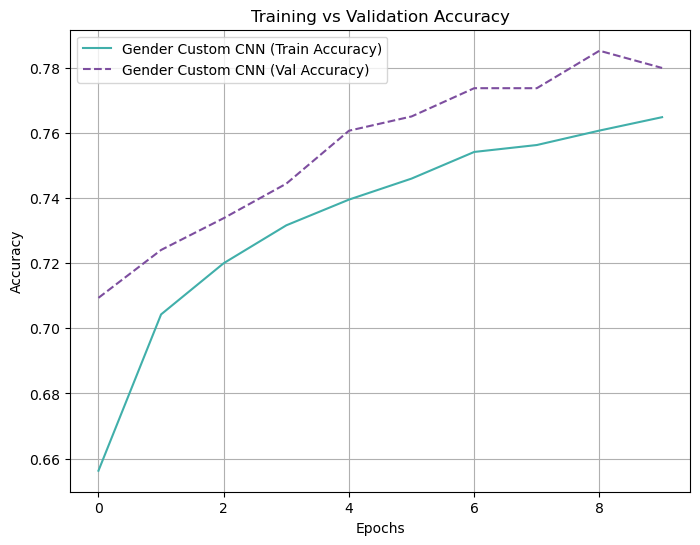

In [315]:

plot_accuracy({"Gender Custom CNN": custom_gender_model})

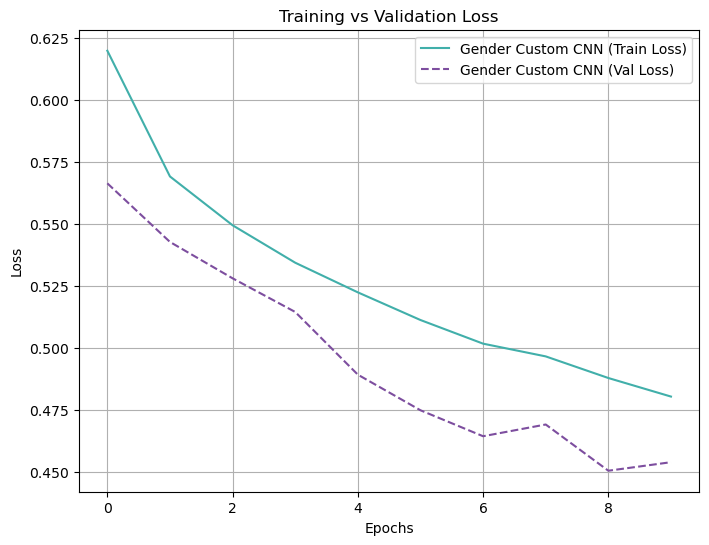

In [317]:
plot_loss({"Gender Custom CNN": custom_gender_model})


343/343 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step


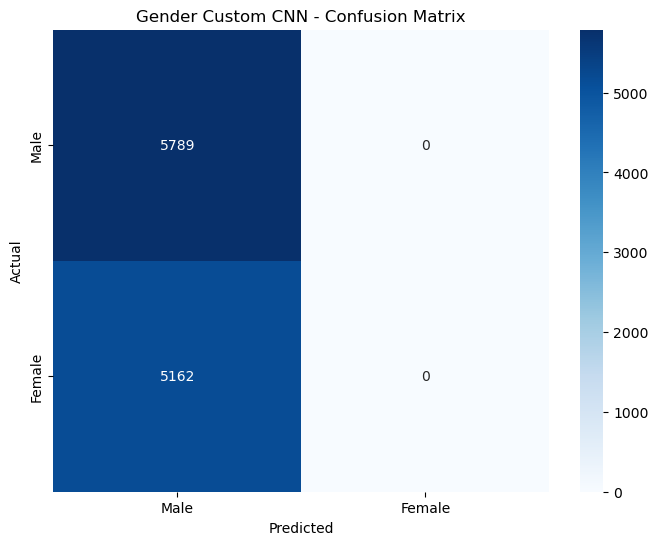

In [319]:
gender_labels = ["Male", "Female"]
plot_confusion_matrix(
    custom_gender_model.model, 
    val_generator, 
    class_labels=gender_labels, 
    title="Gender Custom CNN - Confusion Matrix"
)


In [323]:
print_classification_report(gender_model, val_generator, class_labels=["Male", "Female"])


343/343 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step
Classification Report:
               precision    recall  f1-score   support

        Male       0.53      1.00      0.69      5789
      Female       0.00      0.00      0.00      5162

    accuracy                           0.53     10951
   macro avg       0.26      0.50      0.35     10951
weighted avg       0.28      0.53      0.37     10951



####  7.4.2 Train & Evaluate MobileNetV2  CNN to predict Gender

Found 86559 validated image filenames belonging to 2 classes.
Found 10951 validated image filenames belonging to 2 classes.
Training new model...
Epoch 1/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 365s 133ms/step - accuracy: 0.7683 - loss: 0.4666 - val_accuracy: 0.8164 - val_loss: 0.4168 - learning_rate: 1.0000e-04
Epoch 2/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 400s 148ms/step - accuracy: 0.8564 - loss: 0.3317 - val_accuracy: 0.8758 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 3/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 411s 152ms/step - accuracy: 0.8751 - loss: 0.2914 - val_accuracy: 0.8819 - val_loss: 0.2831 - learning_rate: 1.0000e-04
Epoch 4/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 405s 150ms/step - accuracy: 0.8884 - loss: 0.2641 - val_accuracy: 0.8817 - val_loss: 0.2782 - learning_rate: 1.0000e-04
Epoch 5/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 381s 141ms/step - accuracy: 0.8973 - loss: 0.2434 - val_accuracy: 0.8892 - val_loss: 0.2640 - learning_rate: 1.0000e-04
Epoch 6/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 40

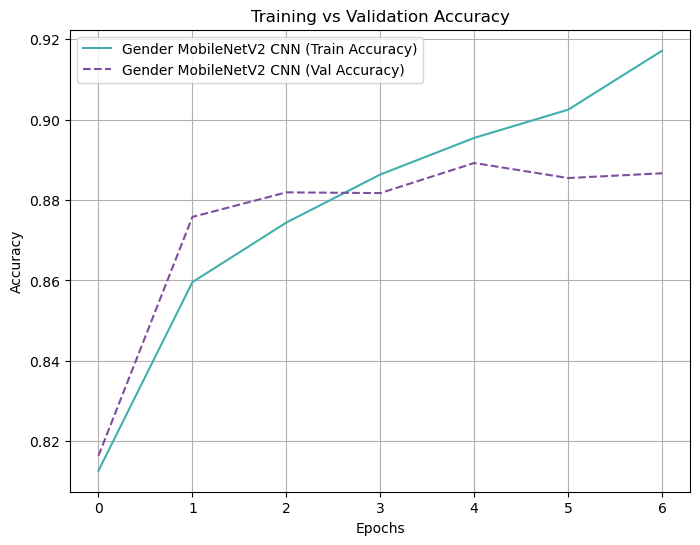

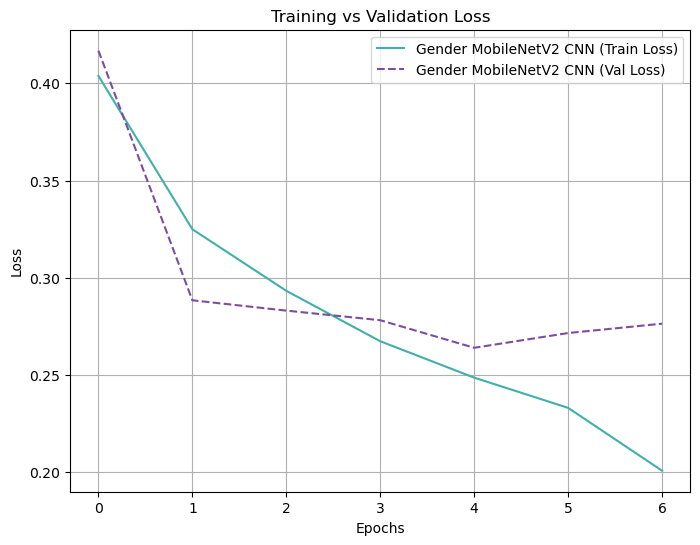

In [91]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Hyperparameters
IMG_SIZE = (160, 160)  # Increased resolution for better feature extraction
BATCH_SIZE = 32  # Reduced batch size to prevent excessive memory usage
EPOCHS = 10  # Can adjust based on results
LEARNING_RATE = 0.0001
MODEL_FILENAME = "mobilev2_gender_model_finetuned.keras"

# Ensure gender column is string
df_train["gender"] = df_train["gender"].astype(str)
df_val["gender"] = df_val["gender"].astype(str)

# Load MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights="imagenet")

# Unfreeze only last 20 layers for fine-tuning
for layer in base_model.layers[:-20]:  
    layer.trainable = False
for layer in base_model.layers[-20:]:  
    layer.trainable = True

# Add classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)  # Regularization to prevent overfitting
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

# Define final model
mobilev2_gender_model = Model(inputs=base_model.input, outputs=output)

# Compile model
mobilev2_gender_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                              loss="binary_crossentropy", 
                              metrics=["accuracy"])

# Data generators with augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=train_image_dir, 
    x_col="file", 
    y_col="gender", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=val_image_dir, 
    x_col="file", 
    y_col="gender", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="binary"
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6)

# Train model
if os.path.exists(MODEL_FILENAME):
    print("Model found. Loading existing model...")
    mobilev2_gender_model = load_model(MODEL_FILENAME)
else:
    print("Training new model...")
    mobilev2_gender_model.fit(
        train_generator, 
        validation_data=val_generator, 
        epochs=EPOCHS, 
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Save model in efficient format
    mobilev2_gender_model.save(MODEL_FILENAME)

# Plot accuracy and loss if training history exists
try:
    plot_accuracy({"Gender MobileNetV2 CNN": mobilev2_gender_model.history})
    plot_loss({"Gender MobileNetV2 CNN": mobilev2_gender_model.history})
except Exception as e:
    print("Error plotting training metrics:", str(e))


### 7.5 Geographical Ancestry Classification CNN

####  7.5.1 Train & Evaluate Baseline CNN to predict Geographical Ancestry

In [18]:

# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

df_train["race_encoded"] = df_train["race_encoded"].astype(str)
df_val["race_encoded"] = df_val["race_encoded"].astype(str)


# Simplified model architecture for debugging
geo_ancestry_model = build_custom_model(input_shape=(128, 128, 3), num_classes=7)  # 7 classes from encoding

# Compile model
geo_ancestry_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss="categorical_crossentropy", metrics=["accuracy"])

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=train_image_dir, 
    x_col="file", 
    y_col="race_encoded",  
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=val_image_dir, 
    x_col="file", 
    y_col="race_encoded",  
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train model
custom_geo_ancestry_model = geo_ancestry_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS, 
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Found 86559 validated image filenames belonging to 7 classes.
Found 10951 validated image filenames belonging to 7 classes.
Epoch 1/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 229s 85ms/step - accuracy: 0.2452 - loss: 1.8648 - val_accuracy: 0.3420 - val_loss: 1.7223 - learning_rate: 1.0000e-04
Epoch 2/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 230s 85ms/step - accuracy: 0.3275 - loss: 1.7361 - val_accuracy: 0.3640 - val_loss: 1.6670 - learning_rate: 1.0000e-04
Epoch 3/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 228s 84ms/step - accuracy: 0.3543 - loss: 1.6812 - val_accuracy: 0.3985 - val_loss: 1.6057 - learning_rate: 1.0000e-04
Epoch 4/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 229s 85ms/step - accuracy: 0.3788 - loss: 1.6402 - val_accuracy: 0.3991 - val_loss: 1.5821 - learning_rate: 1.0000e-04
Epoch 5/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 672s 248ms/step - accuracy: 0.3891 - loss: 1.6131 - val_accuracy: 0.4236 - val_loss: 1.5360 - learning_rate: 1.0000e-04
Epoch 6/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 228s 84ms/step - accuracy: 0

In [50]:
save_model(custom_geo_ancestry_model.model, "simple_geo_ancestry_model")

Model saved as simple_geo_ancestry_model.h5


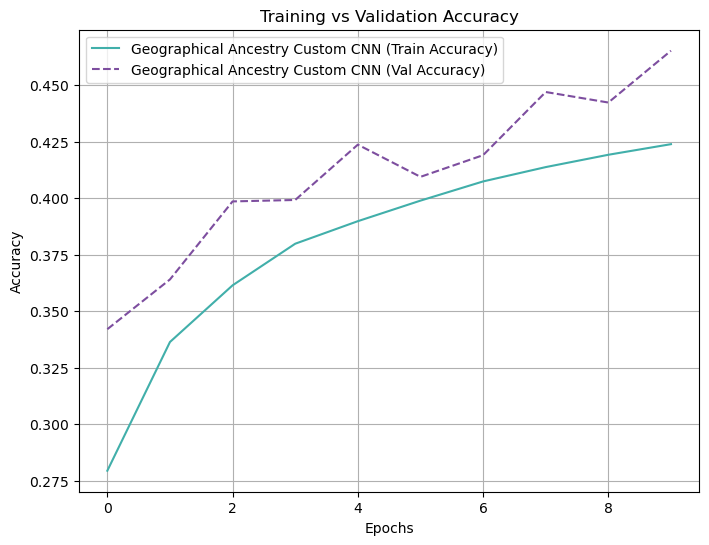

In [113]:
plot_accuracy({"Geographical Ancestry Custom CNN": custom_geo_ancestry_model})

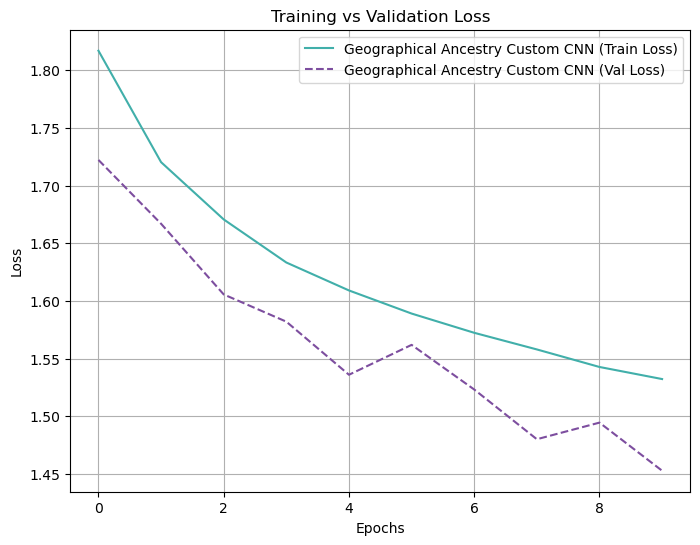

In [115]:
plot_loss({"Geographical Ancestry Custom CNN": custom_geo_ancestry_model})


343/343 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step


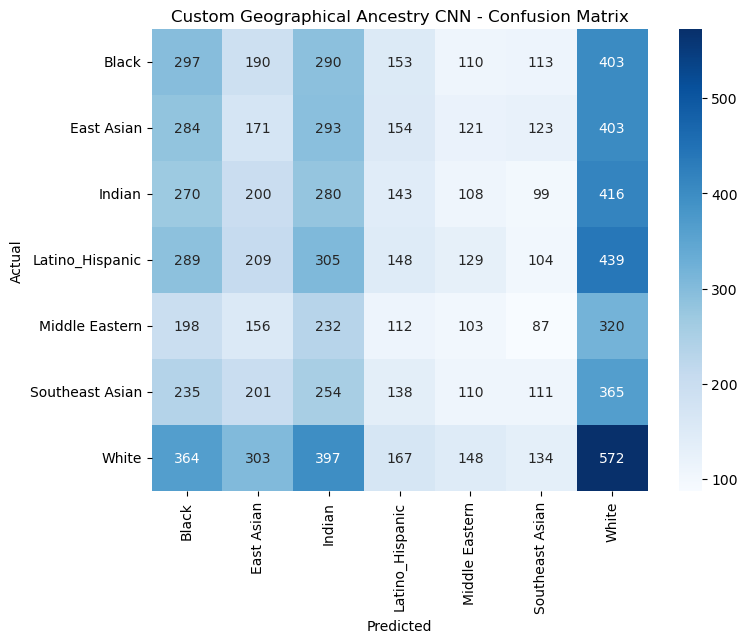

In [56]:
correct_geo_labels = ["Black", "East Asian", "Indian", "Latino_Hispanic", "Middle Eastern", "Southeast Asian", "White"]
plot_confusion_matrix(
    custom_geo_ancestry_model.model, 
    val_generator, 
    class_labels=correct_geo_labels, 
    title="Custom Geographical Ancestry CNN - Confusion Matrix"
)


In [57]:
print_classification_report(custom_geo_ancestry_model.model, val_generator, class_labels=correct_geo_labels)

343/343 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step
Classification Report:
                  precision    recall  f1-score   support

          Black       0.14      0.18      0.16      1556
     East Asian       0.14      0.13      0.13      1549
         Indian       0.14      0.19      0.16      1516
Latino_Hispanic       0.14      0.09      0.11      1623
 Middle Eastern       0.11      0.08      0.09      1208
Southeast Asian       0.14      0.08      0.10      1414
          White       0.19      0.26      0.22      2085

       accuracy                           0.15     10951
      macro avg       0.14      0.14      0.14     10951
   weighted avg       0.15      0.15      0.14     10951



####  7.5.2 Train & Evaluate MobileNetV2  CNN to predict Geographical Ancestry

In [92]:
from tensorflow.keras.applications import MobileNetV2
# Hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001

# Ensure the target column is of string type
df_train["race_encoded"] = df_train["race_encoded"].astype(str)
df_val["race_encoded"] = df_val["race_encoded"].astype(str)

# Load MobileNetV2 as base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model weights

# Add classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(7, activation="softmax")(x)  # 7 classes for geographical ancestry

# Define final model
mobilev2_geo_model = Model(inputs=base_model.input, outputs=output)

# Compile model
mobilev2_geo_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                           loss="categorical_crossentropy", 
                           metrics=["accuracy"])

# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=train_image_dir, 
    x_col="file", 
    y_col="race_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=val_image_dir, 
    x_col="file", 
    y_col="race_encoded", 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode="categorical"
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

# Train model
mobilev2_geo_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCHS, 
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# Save model
mobilev2_geo_model.save("mobilev2_geo_model.h5")


Found 86559 validated image filenames belonging to 7 classes.
Found 10951 validated image filenames belonging to 7 classes.
Epoch 1/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 283s 103ms/step - accuracy: 0.2687 - loss: 1.8543 - val_accuracy: 0.3579 - val_loss: 1.6786 - learning_rate: 1.0000e-04
Epoch 2/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 279s 103ms/step - accuracy: 0.3558 - loss: 1.6678 - val_accuracy: 0.3736 - val_loss: 1.6369 - learning_rate: 1.0000e-04
Epoch 3/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 279s 103ms/step - accuracy: 0.3730 - loss: 1.6343 - val_accuracy: 0.3775 - val_loss: 1.6279 - learning_rate: 1.0000e-04
Epoch 4/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 279s 103ms/step - accuracy: 0.3812 - loss: 1.6182 - val_accuracy: 0.3851 - val_loss: 1.6088 - learning_rate: 1.0000e-04
Epoch 5/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 282s 104ms/step - accuracy: 0.3872 - loss: 1.6013 - val_accuracy: 0.3847 - val_loss: 1.6072 - learning_rate: 1.0000e-04
Epoch 6/10
2705/2705 ━━━━━━━━━━━━━━━━━━━━ 286s 106ms/step - accura

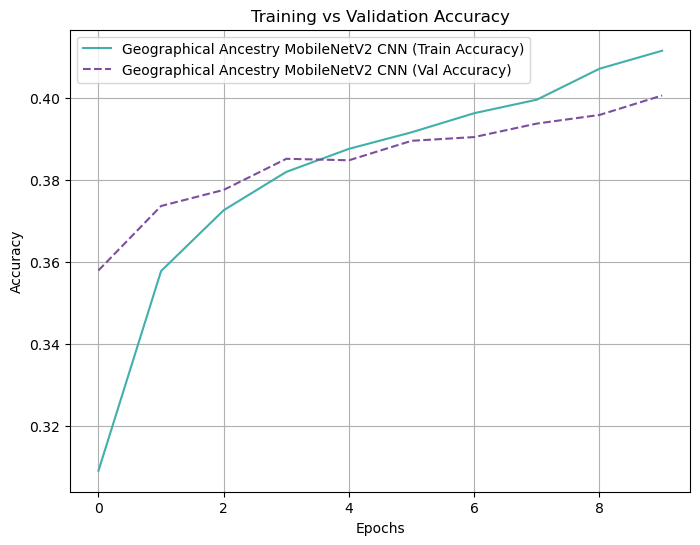

In [94]:
plot_accuracy({"Geographical Ancestry MobileNetV2 CNN": mobilev2_geo_model.history})

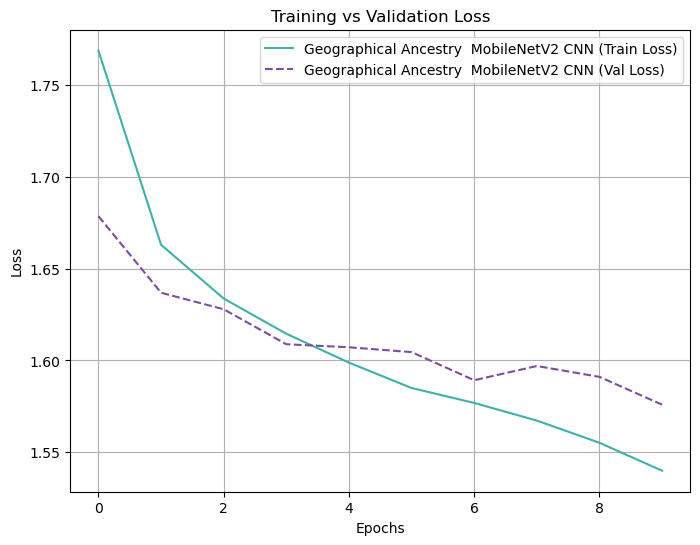

In [95]:
plot_loss({"Geographical Ancestry  MobileNetV2 CNN": mobilev2_geo_model.history})


343/343 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step


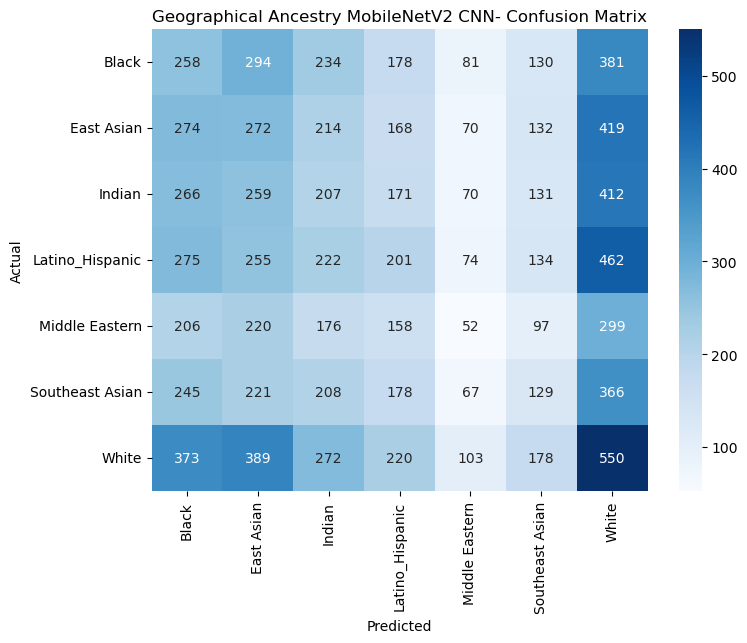

In [99]:
correct_geo_labels = ["Black", "East Asian", "Indian", "Latino_Hispanic", "Middle Eastern", "Southeast Asian", "White"]
plot_confusion_matrix(
    mobilev2_geo_model, 
    val_generator, 
    class_labels=correct_geo_labels, 
    title="Geographical Ancestry MobileNetV2 CNN- Confusion Matrix"
)

In [ ]:
print_classification_report(mobilev2_geo_model.model, val_generator, class_labels=correct_geo_labels)